## Imports

In [1]:
import csv
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.pyplot import cm

import numpy as np
import trompy as tp
from datetime import datetime
import pandas as pd
import pickle 

%matplotlib inline


from scipy import stats
from scipy.stats import gaussian_kde

In [41]:
def extract_event_fn(filename): 
    '''
    function to extract framenumber of events (licks and pump_on) in framenumber
    
    args
    filename - string 
    
    returns 
    licks_fn - lits of integers
        framenumber of licks
    pump_on_fn - list of integers 
        framenumber when pump turns on
    
    '''
    df= pd.read_csv(filename)
    
    #Extracts pump on framenumber
    pump_fn = list(df[df['Item1'] == 'pump_on']['Item2.Item2'])
    
    
    #Extracts licks framenumber
    licks_fn = list (df[df['Item1']== 'Lick']['Item2.Item2'])

      
    return pump_fn, licks_fn
        


In [42]:
def get_hit_miss_trial (pump_fn, licks_fn): 
    '''
    function to get hit and miss trials
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    hit_trial - list of int 
        pump on frame number in hit trials (lick > 0)
    miss_trial - list of int 
        pump on frame number in missed trials (lick = 0)
    
    '''
    hit_trial=[]
    miss_trial=[]
    for p in pump_fn: 
        temp=[]
        for lick in licks_fn: 
            if lick > p and lick < p + 100: 
                temp.append(lick)
            
        if len(temp)> 0:
            hit_trial.append(p)
        if len(temp) == 0: 
            miss_trial.append(p)
    return hit_trial, miss_trial

In [212]:
def get_licks_trial (pump_fn, licks_fn, triallength=100):
    '''
    function to get licks within one trial 
    licks aligned to pump on (pump_fn)
    
    arg 
    pump_fn - list of integers
        framenumber for when the pump turns on 
    licks_fn - list of integers
        framenumber for all licks
    triallenght - int float (optional, default set to 100 frames (10sec))
    
    returns 
    licks_trial - list of list of integers
        list of all licks in all trials aligned to pump on (in frames)
    licks_all_trial - list of integers
        number of licks of each trial 
    licks_hit_trial - list of integers 
        number of licks per trial for hit trials 
    latency - list of integers
        latency to first lick after pump on (in frames)
        
    
    '''

    # All licks aligned to pump on 
    licks_trial=[]
    for p in pump_fn:
        temp=[]
        for lick in licks_fn: 
            if lick > (p-50) and lick < p + 100:
                temp.append(lick - p)
        licks_trial.append(temp)
        
        
    #licks per trial (all and hit trials) aligned to pump on 
    licks_all_trial=[]
    licks_hit_trial=[]
    for trial in licks_trial: 
        licks_all_trial.append(len(trial))
        if len(trial) > 0: 
            licks_hit_trial.append(len(trial))
            
            
    #Latency to first lick after pump on
    temp_latency=[]
    latency_all_temp=[]
    for trial in licks_trial:
        latency_all_temp.append(trial[:1])
        if len(trial) > 0: 
            temp_latency.append(trial[:1])
        
            
    
    latency=[trial for sublist in temp_latency for trial in sublist] #List comprehension to convert list of lists to flat list     
    
        
    return licks_trial, licks_all_trial, licks_hit_trial, latency, latency_all_temp

In [213]:
def get_binned_latency(latency_all): 
    '''
    function to get mean latency for binned trials  
    bins = 10 trials 
    
    args
    latency_all - list of lists of int
        list all the latencies to first lick in each trial. if no lick list is empty 
        
    returns 
    latency1/2/3/4 - float 
        the mean latency for hit trials in 4 different bins (10 trial per bin)
    '''
    bin1=tp.flatten_list(latency_all[:10])
    bin2=tp.flatten_list(latency_all[10:20])
    bin3=tp.flatten_list(latency_all[20:30])
    bin4=tp.flatten_list(latency_all[30:])

    latency1=np.mean(bin1)
    latency2=np.mean(bin2)
    latency3=np.mean(bin3)
    latency4=np.mean(bin4)
    
    return latency1,latency2,latency3,latency4

In [214]:
def get_grouped_latencybin(diet,solution, session):

    bin1=[]
    bin2=[]
    bin3=[]
    bin4=[]

    for key in all_data.keys():
        d=all_data[key]
        if d['solution']== solution and d['diet'] == diet and d['session'] == session and len(d['pump_fn']) > 30: 
            if d['latency1'] > 0:
                bin1.append(d['latency1'])
            if d['latency2'] > 0:
                bin2.append(d['latency2'])
            if d['latency3'] > 0:
                bin3.append(d['latency3'])
            if d['latency4'] > 0:
                bin4.append(d['latency4'])
        


    b1_m=np.mean(bin1)
    b1_E=np.std(bin1, ddof=1) / np.sqrt(np.size(bin1))
    b2_m=np.mean(bin2)
    b2_E=np.std(bin2, ddof=1) / np.sqrt(np.size(bin2))
    b3_m=np.mean(bin3)
    b3_E=np.std(bin3, ddof=1) / np.sqrt(np.size(bin3))
    b4_m=np.mean(bin4)
    b4_E=np.std(bin4, ddof=1) / np.sqrt(np.size(bin4))
    
    mean=[b1_m,b2_m,b3_m,b4_m]
    error=[b1_E,b2_E,b3_E,b4_E]
    
    
    return mean,error
    

In [215]:
def get_binned_hit (data): 
    
    bin1=data[:10]
    bin2=data[10:20]
    bin3=data[20:30]
    bin4=data[30:]


    hit1=[]
    miss1=[]
    for trial in bin1: 
        if len(trial)>0: 
            hit1.append(trial[:1])
        elif len(trial)==0: 
            miss1.append(trial)
        
    try: 
        p_bin1 =(len(hit1)/(len(hit1)+len(miss1)))*100
    except ZeroDivisionError:
        p_bin1=np.nan

    hit2=[]
    miss2=[]
    for trial in bin2: 
        if len(trial)>0: 
            hit2.append(trial[:1])
        elif len(trial)==0: 
            miss2.append(trial)
            
    try: 
        p_bin2 =(len(hit2)/(len(hit2)+len(miss2)))*100
    except ZeroDivisionError:
        p_bin2=np.nan

    hit3=[]
    miss3=[]
    for trial in bin3: 
        if len(trial)>0: 
            hit3.append(trial[:1])
        elif len(trial)==0: 
            miss3.append(trial)
            
    try: 
        p_bin3 =(len(hit3)/(len(hit3)+len(miss3)))*100
    except ZeroDivisionError:
        p_bin3=np.nan
    

    hit4=[]
    miss4=[]
    for trial in bin4:
        if len(trial)>0: 
            hit4.append(trial[:1])
        elif len(trial)==0: 
            miss4.append(trial)
            
    try: 
        p_bin4 =(len(hit4)/(len(hit4)+len(miss4)))*100
    except ZeroDivisionError:
        p_bin4=np.nan
            
    
    
    return p_bin1,p_bin2,p_bin3,p_bin4

In [216]:
def make_barscatter(data, ax=None, barlabels=['PR','PRNR','NR','NRPR'], barfacecolor = ['darkcyan','c', 'black', 'grey']):
    
    '''
    function to make barscatter
    
    arg 
    data - list of lists of floats
        The data you want to put into the plot
    barlabels - list of strings
        labels for the bars plotted (optional - defaulte : 'PR','PRNR','NR','NRPR' )
    barfacecolors - list of strings
        colors for the bars (optional- default: ['darkcyan','c', 'black', 'grey'])
    
    
    returns 
    ax - ax to put into sublot
    
    '''
    if ax == None: 
        f,ax = plt.subplots()
        
    tp.barscatter(data, 
                  paired= True,
                  barfacecolor=barfacecolor,
                  barlabels=barlabels,
                  barlabeloffset=0.04,
                  barfacecolor_option='individual',
                  fontsize = 13,
                  scattersize=110,
                  scatteralpha=0.7,
                  spaced=True,
                  linewidth=1.5,
                  ax=ax)
    
    return ax
    

In [217]:
def get_cumulative_licks(licks_fn): 
    '''
    function to get cumulative licks. 
    lick frame number put into bins and calculated as cumulative
    
    args 
    licks_fn - list of floats 
        the framenumber of all licks in the session 
    bins - float - optional default set to 100 (10 sec)
        size of bins
        
    returns
    lickcum - array of cumulative licks 
    lickbin - array of bins '''
    
    bins=list(range(0,12900,10))
    licks, b = np.histogram(licks_fn, bins=bins)
    lickcum = np.cumsum(licks)
    lickbin = b[1:]
    
    return lickcum, lickbin

In [218]:
def get_grouped_data(dictionary, solution, data ):
    '''
    function to group data and get output from animals grouped into PR, PRNR, NR and NRPR
    
    args
    dictionary - name of dictionaty (eks behav_data)
    solution - string 
        the name of the soltuion, given as a key in the dictionaty (eks 'Ensure')
    data - string
        name of the data/output you want as output (eks 'total licks') 
        
        
        
    '''
    
    PR=[]
    PRNR=[]
    
    NR=[]
    NRPR=[]
    
    for mouse in mice: 
        temp_PR=[]
        temp_PRNR=[]
        
        temp_NR=[]
        temp_NRPR=[]
        
        for key in dictionary.keys():
            d=dictionary[key]
            
            if d['mouse']== mouse and d['solution']==solution and d['diet']== 'PR': 
                temp_PR.append(d[data])
                temp_PR = [element for element in temp_PR if not np.isnan(element)]
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'NR':
                temp_NR.append(d[data])
                temp_NR = [element for element in temp_NR if not np.isnan(element)]
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'PRNR':
                temp_PRNR.append(d[data])
                temp_PRNR = [element for element in temp_PRNR if not np.isnan(element)]
            elif d['mouse']==mouse and d['solution']==solution and d['diet']== 'NRPR':
                temp_NRPR.append(d[data])
                temp_NRPR = [element for element in temp_NRPR if not np.isnan(element)]
                
        if len(temp_PR)> 0:
            PR.append(np.mean(temp_PR))
        if len(temp_NR)>0:
            NR.append(np.mean(temp_NR))
        if len(temp_PRNR)>0:
            PRNR.append(np.mean(temp_PRNR))
        if len(temp_NRPR)>0:
            NRPR.append(np.mean(temp_NRPR))
            
    return PR, PRNR, NR, NRPR
                
        

In [219]:
def grouped_by_session(dictionary, solution,session, output):
    
    
    PR=[]
    PRNR=[]
    
    NR=[]
    NRPR=[]
    
    for key in dictionary.keys():
            d=dictionary[key]
            
            if d['solution']== solution and d['diet'] == 'PR' and d['session'] == session: 
                PR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'PRNR' and d['session'] == session: 
                PRNR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'NR' and d['session'] == session: 
                NR.append(np.mean(d[output]))
            elif d['solution']== solution and d['diet'] == 'NRPR' and d['session'] == session: 
                NRPR.append(np.mean(d[output]))
                
                
    return PR, PRNR, NR, NRPR
        
   

In [220]:
def get_kde(licks_fn, band_width=0.2):
    # Exclude empty lists and flatten the remaining lists
    flattened_data = [item for sublist in licks_fn if sublist for item in sublist]
    
    # Create the Gaussian KDE
    G = gaussian_kde(flattened_data, bw_method=band_width)
    
    # Define the range of values for which you want the KDE
    x = np.arange(-50, 100)
    
    return G(x)






## Metafile reader

In [221]:
rows,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.3.xls',sheetname='Behavior')
# rows_homecage,header=tp.metafilereader('C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\Metafile_VGP2.2.xls',sheetname='Homecage')
folder= 'C:\\Users\\mko102\\UiT Office 365\\O365-Pipette 2 - Dokumenter\\People\\Mette\\GitHub\\2P\\VGP2\\Bonsai\\'

File is excel file. Making csv metafile first


## Dictionary

In [222]:
all_data={}

for row in rows: 
    try:
        key=row[0]+ '_' + row[4]
    
        pump_fn, licks_fn = extract_event_fn(folder+row[1])
        hit_trial, miss_trial = get_hit_miss_trial(pump_fn, licks_fn)
        licks_trial, licks_all_trial, licks_hit_trial, latency, latency_all = get_licks_trial(pump_fn, licks_fn)
        cumlicks, bins = get_cumulative_licks(licks_fn)
        
        
        latency1, latency2, latency3, latency4 = get_binned_latency(latency_all)
#         if len(pump_fn) > 30: 

        hit1, hit2, hit3, hit4 = get_binned_hit(latency_all)
    
        
        
    
        all_data[key]={}

        all_data[key]['mouse']=row[0]
        all_data[key]['diet']=row[7]
        all_data[key]['solution']=row[8]
        all_data[key]['session']=row[10]
    
#         all_data[key]['file']=row[1]
#         all_data[key]['licks_fn']= licks_fn
#         all_data[key]['pump_fn']= pump_fn
        all_data[key]['licks trial']= licks_trial
#         all_data[key]['number of trials']=len(pump_fn)
        all_data[key]['total licks']=len(licks_fn)
#         all_data[key]['hit trial'] = len(hit_trial)
        all_data[key]['% hit']=(len(hit_trial)/(len(pump_fn))*100)
#         all_data[key]['miss trials']= len(miss_trial)
        all_data[key]['licks per trial']= np.mean(licks_all_trial)
        all_data[key]['licks hit trial']= np.mean(licks_hit_trial)
        all_data[key]['latency']= np.mean(latency)
        
#         all_data[key]['latency all']=latency_all
        all_data[key]['latency1']=latency1
        all_data[key]['latency2']=latency2
        all_data[key]['latency3']=latency3
        all_data[key]['latency4']=latency4
        
        all_data[key]['hit 1']= hit1
        all_data[key]['hit 2']= hit2
        all_data[key]['hit 3']= hit3
        all_data[key]['hit 4']= hit4
        
        
        all_data[key]['cumulative licks']=cumlicks
        all_data[key]['lick bins']=bins
        
    
    except FileNotFoundError: 
        print('Cannot find file for', key)

C:\Users\mko102\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\mko102\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Cannot find file for _


In [223]:

with open('..//output//behavdata.pickle', 'wb') as file:
    pickle.dump(all_data, file, protocol=pickle.HIGHEST_PROTOCOL)

with open('..//output//behavdata.pickle', 'rb') as file:
    b = pickle.load(file)

In [224]:
mice=[]

for key in all_data.keys(): 
    d=all_data[key]
    mouseid=d['mouse']
    if mouseid not in mice: mice.append(mouseid)


for m in mice: 
    if m == 'VGP305':
        mice.remove(m)



mice

['VGP118',
 'VGP202',
 'VGP203',
 'VGP204',
 'VGP302',
 'VGP310',
 'VGP306',
 'VGP307',
 'VGP402',
 'VGP403',
 'VGP404',
 'VGP501',
 'VGP502',
 'VGP503',
 'VGP504',
 'VGP505',
 'VGP506',
 'VGP509']

# Licks per session

## Baseline all animals

In [225]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['total licks'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['total licks'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))



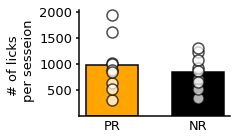

In [226]:
# Making figure for total licks - Mean per animal

f,ax=plt.subplots(figsize=(3.5,2), ncols=1, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.3)

colors_B=['orange','black']


ax= make_barscatter([[baseline_PR],[baseline_NR]], ax=ax, barfacecolor=colors_B, barlabels=['PR','NR'])


ax.set_ylabel('# of licks \n per sesseion',fontsize = 13)
ax.set_yticks([500,1000,1500,2000])
ax.set_yticklabels([500,1000,1500,2000], fontsize = 13)




f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_baseline.pdf')

### stats

In [227]:
#t-test

t_value,p_value=stats.ttest_ind(baseline_PR,baseline_NR)
print('T-test (PR NR - baseline) = %f'%p_value)


T-test (PR NR - baseline) = 0.553563


Ensure, casein and maltodextrin

In [228]:
# Total licks Ensure
ensure_PR,ensure_PRNR,ensure_NR,ensure_NRPR= get_grouped_data(all_data, 'Ensure', 'total licks')
# Total licks Casein
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', 'total licks')
# Total licks Maltodextrin
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', 'total licks')


## Figures - licks per session

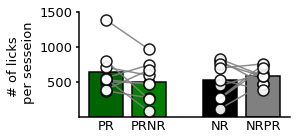

In [229]:
#Figure total licks Ensure

f,ax=plt.subplots(figsize=(4.5,2), ncols=1, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.25)

colors_E=['Darkgreen','green','black', 'grey']

tp.barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], 
              paired= True,
              barfacecolor=colors_E,
              barfacecolor_option="individual",
              barlabels=['PR', 'PRNR', 'NR', 'NRPR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax,
              show_legend=False)






ax.set_ylabel('# of licks \n per sesseion',fontsize = 13)
ax.set_yticks([500,1000,1500])
ax.set_yticklabels([500,1000,1500], fontsize = 13)


# ax.set_title('Ensure', fontsize =13)



f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_ensure.pdf')

Stats

In [230]:
t_value,p_value=stats.ttest_ind(ensure_PR,ensure_NR)
print('T-test (PR NR) = %f'%p_value)

t_value,p_value=stats.ttest_ind(ensure_PR,ensure_PRNR)
print('T-test(PR PRNR) = %f'%p_value)

t_value,p_value=stats.ttest_ind(ensure_NR,ensure_NRPR)
print('T-test(NR NRPR) = %f'%p_value)

t_value,p_value=stats.ttest_ind(ensure_PRNR,ensure_NRPR)
print('T-test(PRNR NRPR) = %f'%p_value)

T-test (PR NR) = 0.391040
T-test(PR PRNR) = 0.320636
T-test(NR NRPR) = 0.515354
T-test(PRNR NRPR) = 0.402730


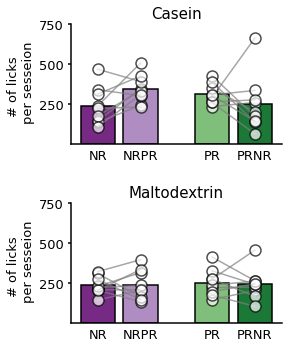

In [231]:
#Figure total licks Cas/Malt

f,ax=plt.subplots(figsize=(4.5,5), ncols=1, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.5, bottom=0.05, left=0.25)

#  {'NR': '#525252', 'NRPR': '#969696', 'PR': '#2171b5','PRNR':'#6baed6'}


colors_C=['#762a83', '#af8dc3','#7fbf7b','#1b7837']
colors_M=['#762a83', '#af8dc3','#7fbf7b','#1b7837']

ax[0]= make_barscatter([[cas_NR,cas_NRPR],[cas_PR,cas_PRNR]], ax=ax[0],barfacecolor= colors_C, barlabels=['NR','NRPR','PR','PRNR'])
ax[1] = make_barscatter([[malt_NR,malt_NRPR],[malt_PR,malt_PRNR]], ax=ax[1],barfacecolor= colors_M,barlabels=['NR','NRPR','PR','PRNR'])



ax[0].set_ylabel('# of licks \n per sesseion',fontsize = 13)
ax[0].set_yticks([250,500,750])
ax[0].set_yticklabels([250,500,750], fontsize = 13)

ax[1].set_ylabel('# of licks \n per sesseion',fontsize = 13)
ax[1].set_yticks([250,500,750])
ax[1].set_yticklabels([250,500,750], fontsize = 13)


ax[0].set_title('Casein', fontsize =15)
ax[1].set_title('Maltodextrin', fontsize =15)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_cm.png')




In [232]:
print('Total Licks')


t_value,p_value=stats.ttest_ind(cas_PR,cas_NR)
print('T-test (PR NR_C) = %f'%p_value)

t_value,p_value=stats.ttest_ind(malt_PR,malt_NR)
print('T-test (PR NR_M) = %f'%p_value)

t_value,p_value=stats.ttest_ind(malt_PR,cas_PR)
print('T-test(PR C_M) = %f'%p_value)

t_value,p_value=stats.ttest_ind(malt_NR,cas_NR)
print('T-test(NR C_M) = %f'%p_value)


t_value,p_value=stats.ttest_ind(cas_PRNR,cas_NRPR)
print('T-test (PRNR NRPR_C) = %f'%p_value)
t_value,p_value=stats.ttest_ind(malt_PRNR,malt_NRPR)
print('T-test (PRNR NRPR_M) = %f'%p_value)


t_value,p_value=stats.ttest_ind(malt_NRPR,cas_NRPR)
print('T-test(NRPR C_M) = %f'%p_value)
t_value,p_value=stats.ttest_ind(malt_PRNR,cas_PRNR)
print('T-test(PRNR C_M) = %f'%p_value)

Total Licks
T-test (PR NR_C) = 0.106365
T-test (PR NR_M) = 0.635919
T-test(PR C_M) = 0.098194
T-test(NR C_M) = 0.977512
T-test (PRNR NRPR_C) = 0.174913
T-test (PRNR NRPR_M) = 0.931024
T-test(NRPR C_M) = 0.025666
T-test(PRNR C_M) = 0.913358


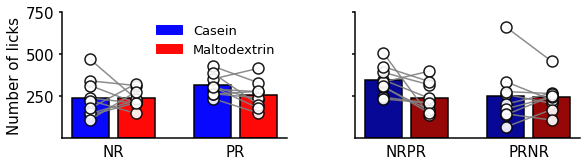

In [233]:
# Figure NR- cas/malt - PR- cas/malt 

f,ax=plt.subplots(figsize=(9,3), ncols=2, sharey=False)
f.subplots_adjust(wspace=0.3, bottom=0.3, left=0.1)

colors_1=['#0808FF','#FF0808','#0808FF','#FF0808']
colors_2=['#080896','#960808','#080896','#960808']





tp.barscatter([[cas_NR,malt_NR],[cas_PR,malt_PR]], 
              paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[0],
              grouplabel=['NR','PR'],
              show_legend=False)




tp.barscatter([[cas_NRPR,malt_NRPR],[cas_PRNR,malt_PRNR]], 
              paired= True,
              barfacecolor=colors_2,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[1],
              grouplabel=['NRPR','PRNR'],
              show_legend=False)


ax[0].set_ylabel('Number of licks',fontsize = 15)
ax[0].set_yticks([250,500,750])
ax[0].set_yticklabels([250,500,750], fontsize = 15)


ax[1].set_yticks([250,500,750])
ax[1].set_yticklabels([])



colors = {'Casein':'#0808FF', 'Maltodextrin':'#FF0808'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]
ax[0].legend(handles, labels, fontsize=13, frameon=False)



f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_casmalt.png')



## Preference for casein - total licks

In [234]:

#Preference for PR 
pref_PR=[]
for cas in cas_PR:
    pref_temp=[]
    for malt in malt_PR: 
        pref_temp=(cas/(cas+malt))
    pref_PR.append(pref_temp)
    
pref_PR  

# Preference for NR 

pref_NR=[]
for cas in cas_NR:
    pref_temp=[]
    for malt in malt_NR: 
        pref_temp=(cas/(cas+malt))
    pref_NR.append(pref_temp)
    
pref_NR  

# Preference for PRNR 

pref_PRNR=[]
for cas in cas_PRNR:
    pref_temp=[]
    for malt in malt_PRNR: 
        pref_temp=(cas/(cas+malt))
    pref_PRNR.append(pref_temp)
    
pref_PRNR  


# Preference for NRPR 

pref_NRPR=[]
for cas in cas_NRPR:
    pref_temp=[]
    for malt in malt_NRPR: 
        pref_temp=(cas/(cas+malt))
    pref_NRPR.append(pref_temp)
    
pref_NRPR

[0.6211340206185567,
 0.7014218009478673,
 0.7750573833205815,
 0.6723625557206538,
 0.6114537444933921,
 0.6931106471816284,
 0.7264267990074442,
 0.7428571428571428,
 0.6762114537444934]

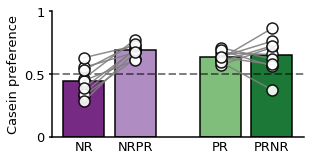

In [235]:

f,ax=plt.subplots(figsize=(5,3), ncols=1, sharey=False)
f.subplots_adjust(wspace=0.3, bottom=0.3, left=0.2)


colors_1=['#762a83', '#af8dc3','#7fbf7b','#1b7837']


tp.barscatter([[pref_NR,pref_NRPR],[pref_PR,pref_PRNR]], 
              paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              barlabels=['NR', 'NRPR','PR', 'PRNR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax,
              show_legend=False)


ax.set_ylabel('Casein preference',fontsize = 13)
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1], fontsize = 13)

ax.axhline(0.5, color='black', alpha=0.5, linewidth=2, linestyle='--')

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\preference_total.png')


In [236]:
NR_pref2=[]
for row in pref_NR: 
    NR_pref2.append(row - 0.5)
    
NRPR_pref2=[]
for row in pref_NRPR: 
    NRPR_pref2.append(row - 0.5)
    
PR_pref2=[]
for row in pref_PR: 
    PR_pref2.append(row - 0.5)
    
PRNR_pref2=[]
for row in pref_PRNR: 
    PRNR_pref2.append(row - 0.5)

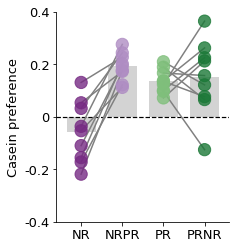

In [237]:
f, ax = plt.subplots(figsize=(4,4))
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.3)


x1=[1,2]
x2=[3,4]

for row in zip(NR_pref2,NRPR_pref2):
    y1=row
    ax.plot(x1,y1, color='grey')
    ax.scatter(x1,y1, s=150, color=["#762a83", "#af8dc3"], zorder=20, alpha=0.8)
    
for row in zip(PR_pref2,PRNR_pref2):
    y2=row
    ax.plot(x2,y2, color='grey')
    ax.scatter(x2,y2, s=150, color=["#7fbf7b", "#1b7837"], zorder=20, alpha=0.8)
    

    
ax.bar(x1, [np.mean(NR_pref2),np.mean(NRPR_pref2)], width=0.7, zorder=-1, color="lightgrey")
ax.bar(x2, [np.mean(PR_pref2),np.mean(PRNR_pref2)], width=0.7, zorder=-1, color="lightgrey")
    
ax.set_ylabel("Casein preference", size=13)
ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
ax.set_yticklabels([-0.4,-0.2,0,0.2,0.4], size=13)



ax.set_xticks([1,2,3,4])
ax.set_xticklabels(["NR", 'NRPR','PR','PRNR'], size=13)
ax.set_xlim([0.4,4.6])

ax.axhline(0, color="k", linestyle="--", zorder=-1,lw=1.2)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\preference_scatter.png')

### Stats - casein preference

In [238]:
# paried t-test: 
stats_PR_PRNR=stats.ttest_ind(pref_PR, pref_PRNR)
print('PR_PRNR',stats_PR_PRNR)

stats_NR_NRPR=stats.ttest_ind(pref_NR, pref_NRPR)
print('NR_NRPR',stats_NR_NRPR)

stats_NR_PR=stats.ttest_ind(pref_NR, pref_PR)
print('NR_PR',stats_NR_PR)

stats_NRPR_PRNR=stats.ttest_ind(pref_NRPR, pref_PRNR)
print('NRPR_PRNR',stats_NRPR_PRNR)

PR_PRNR Ttest_indResult(statistic=-0.29608875986220035, pvalue=0.7709707943602166)
NR_NRPR Ttest_indResult(statistic=-5.882320007901333, pvalue=2.3157393849934557e-05)
NR_PR Ttest_indResult(statistic=-4.709438021772539, pvalue=0.00023623768905651856)
NRPR_PRNR Ttest_indResult(statistic=0.811911548482839, pvalue=0.4287569192068137)


# Licks per trial (all)

In [239]:
all_data['VGP302_D31']['licks trial']

[[],
 [24],
 [13, 14],
 [4, 7],
 [-24, 58, 70, 71, 81, 83, 84, 85, 86, 90, 96],
 [-6, -5, -4, 37],
 [8, 9, 10, 15, 21, 44, 57],
 [9, 12],
 [],
 [],
 [33, 39, 44, 46, 62],
 [],
 [-12, 17],
 [],
 [],
 [-30, -29, -7, -5, 14],
 [],
 [-15, -14, -10, -2, 38, 86, 89],
 [],
 [],
 [-27, -26, -25, -24, -21, 48],
 [-47, -45, 62],
 [],
 [],
 [-19, -17, -16, -14, 7, 8, 10, 15],
 [20, 35, 38, 39, 42, 46, 49, 56, 58, 72],
 [-47, -45, -40, -37, -32, -31, -30, -26, -25, -15, -13, -11, 75, 77, 79],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [261]:
PR_cas1=[]
PR_cas2=[]
PR_cas3=[]

NR_cas1=[]
NR_cas2=[]
NR_cas3=[]

    
for mouse in mice:
    temp_PR1=[]
    temp_PR2=[]
    temp_PR3=[]
    
    temp_NR1=[]
    temp_NR2=[]
    temp_NR3=[]
        
    for key in all_data.keys():
        d=all_data[key]
            
        if d['mouse']== mouse and d['solution']=='Cas' and d['diet']== 'PR' and d['session']=='S1': 
            temp_PR1=get_kde(d['licks trial'])
        elif d['mouse']== mouse and d['solution']=='Cas' and d['diet']== 'PR' and d['session']=='S2': 
            temp_PR2=get_kde(d['licks trial'])
        elif d['mouse']== mouse and d['solution']=='Cas' and d['diet']== 'PR' and d['session']=='S3': 
            temp_PR3=get_kde(d['licks trial'])
            
        if d['mouse']== mouse and d['solution']=='Cas' and d['diet']== 'NR' and d['session']=='S1': 
            temp_NR1=get_kde(d['licks trial'])
        elif d['mouse']== mouse and d['solution']=='Cas' and d['diet']== 'NR' and d['session']=='S2': 
            temp_NR2=get_kde(d['licks trial'])
        elif d['mouse']== mouse and d['solution']=='Cas' and d['diet']== 'NR' and d['session']=='S3': 
            temp_NR3=get_kde(d['licks trial'])
            

                
    if len(temp_PR1)> 0:
        PR_cas1.append(temp_PR1)
    if len(temp_PR2)> 0:
        PR_cas2.append(temp_PR2)
    if len(temp_PR3)> 0:
        PR_cas3.append(temp_PR3)
        
        
    if len(temp_NR1)> 0:
        NR_cas1.append(temp_NR1)
    if len(temp_NR2)> 0:
        NR_cas2.append(temp_NR2)
    if len(temp_NR3)> 0:
        NR_cas3.append(temp_NR3)

            


In [262]:
PR_malt1=[]
PR_malt2=[]
PR_malt3=[]

NR_malt1=[]
NR_malt2=[]
NR_malt3=[]

    
for mouse in mice:
    temp_PR1=[]
    temp_PR2=[]
    temp_PR3=[]
    
    temp_NR1=[]
    temp_NR2=[]
    temp_NR3=[]
        
    for key in all_data.keys():
        d=all_data[key]
            
        if d['mouse']== mouse and d['solution']=='Malt.' and d['diet']== 'PR' and d['session']=='S1': 
            temp_PR1=get_kde(d['licks trial'])
        elif d['mouse']== mouse and d['solution']=='Malt.' and d['diet']== 'PR' and d['session']=='S2': 
            temp_PR2=get_kde(d['licks trial'])
        elif d['mouse']== mouse and d['solution']=='Malt.' and d['diet']== 'PR' and d['session']=='S3': 
            temp_PR3=get_kde(d['licks trial'])
            
        if d['mouse']== mouse and d['solution']=='Malt.' and d['diet']== 'NR' and d['session']=='S1': 
            temp_NR1=get_kde(d['licks trial'])
        elif d['mouse']== mouse and d['solution']=='Malt.' and d['diet']== 'NR' and d['session']=='S2': 
            temp_NR2=get_kde(d['licks trial'])
        elif d['mouse']== mouse and d['solution']=='Malt.' and d['diet']== 'NR' and d['session']=='S3': 
            temp_NR3=get_kde(d['licks trial'])
            

                
    if len(temp_PR1)> 0:
        PR_malt1.append(temp_PR1)
    if len(temp_PR2)> 0:
        PR_malt2.append(temp_PR2)
    if len(temp_PR3)> 0:
        PR_malt3.append(temp_PR3)
        
        
    if len(temp_NR1)> 0:
        NR_malt1.append(temp_NR1)
    if len(temp_NR2)> 0:
        NR_malt2.append(temp_NR2)
    if len(temp_NR3)> 0:
        NR_malt3.append(temp_NR3)

            


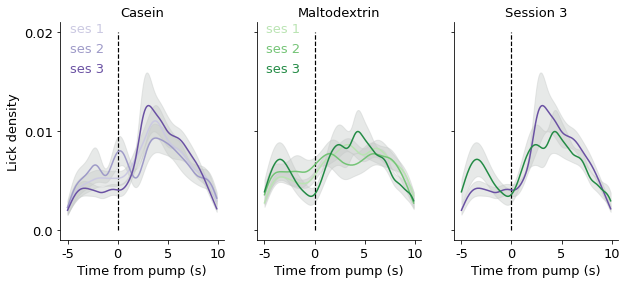

In [276]:
f, ax = plt.subplots(figsize=(10,4),ncols=3, sharey=True)
f1.subplots_adjust(wspace=0.14,hspace=0.1, bottom=0.3, left=0.2, top=0.8)


tp.shadedError(ax[0],PR_cas1, linecolor='#cbc9e2', linestyle='-', linewidth=1.5)
tp.shadedError(ax[0],PR_cas2, linecolor='#9e9ac8', linestyle='-', linewidth=1.5)
tp.shadedError(ax[0],PR_cas3, linecolor='#6a51a3', linestyle='-', linewidth=1.5)

tp.shadedError(ax[1],PR_malt1, linecolor='#bae4b3', linestyle='-', linewidth=1.5)
tp.shadedError(ax[1],PR_malt2, linecolor='#74c476', linestyle='-', linewidth=1.5)
tp.shadedError(ax[1],PR_malt3, linecolor='#238b45', linestyle='-', linewidth=1.5)


tp.shadedError(ax[2],PR_cas3, linecolor='#6a51a3', linestyle='-', linewidth=1.5)
tp.shadedError(ax[2],PR_malt3, linecolor='#238b45', linestyle='-', linewidth=1.5)

ax[0].text(2, 0.02, "ses 1",color='#cbc9e2', size=13)
ax[0].text(2, 0.018, "ses 2", color="#9e9ac8",size=13)
ax[0].text(2, 0.016, "ses 3", color="#6a51a3",size=13)

ax[1].text(2, 0.02, "ses 1",color='#bae4b3', size=13)
ax[1].text(2, 0.018, "ses 2", color="#74c476",size=13)
ax[1].text(2, 0.016, "ses 3", color="#238b45",size=13)

for axis in ax:
    axis.set_xticks([0,50,100,150])
    axis.set_xticklabels(["-5", "0", "5", "10"],rotation=0, size=13)
    axis.set_yticks([0.0, 0.01,0.02])
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.vlines([50],0,0.02, color="black", linestyle="--", linewidth=1.2)
    axis.set_xlabel("Time from pump (s)", size=13)
    
ax[0].set_ylabel("Lick density", size=13)
ax[0].set_yticklabels([0.00, 0.01,0.02], size=13)
    
    
ax[0].set_title('Casein', size=13)
ax[1].set_title('Maltodextrin', size=13)
ax[2].set_title('Session 3', size=13)


f.savefig("..//output//PR_lickdensity_casmalt.pdf")

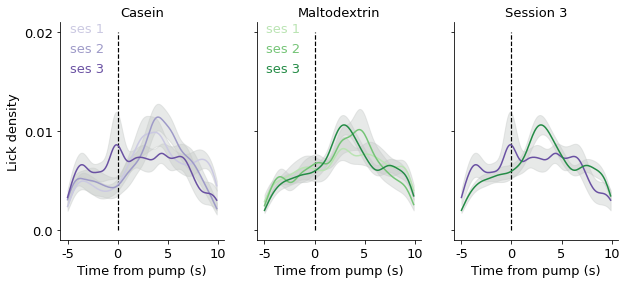

In [277]:
f, ax = plt.subplots(figsize=(10,4),ncols=3, sharey=True)
f1.subplots_adjust(wspace=0.14,hspace=0.1, bottom=0.3, left=0.2, top=0.8)


tp.shadedError(ax[0],NR_cas1, linecolor='#cbc9e2', linestyle='-', linewidth=1.5)
tp.shadedError(ax[0],NR_cas2, linecolor='#9e9ac8', linestyle='-', linewidth=1.5)
tp.shadedError(ax[0],NR_cas3, linecolor='#6a51a3', linestyle='-', linewidth=1.5)

tp.shadedError(ax[1],NR_malt1, linecolor='#bae4b3', linestyle='-', linewidth=1.5)
tp.shadedError(ax[1],NR_malt2, linecolor='#74c476', linestyle='-', linewidth=1.5)
tp.shadedError(ax[1],NR_malt3, linecolor='#238b45', linestyle='-', linewidth=1.5)


tp.shadedError(ax[2],NR_cas3, linecolor='#6a51a3', linestyle='-', linewidth=1.5)
tp.shadedError(ax[2],NR_malt3, linecolor='#238b45', linestyle='-', linewidth=1.5)

ax[0].text(2, 0.02, "ses 1",color='#cbc9e2', size=13)
ax[0].text(2, 0.018, "ses 2", color="#9e9ac8",size=13)
ax[0].text(2, 0.016, "ses 3", color="#6a51a3",size=13)

ax[1].text(2, 0.02, "ses 1",color='#bae4b3', size=13)
ax[1].text(2, 0.018, "ses 2", color="#74c476",size=13)
ax[1].text(2, 0.016, "ses 3", color="#238b45",size=13)

for axis in ax:
    axis.set_xticks([0,50,100,150])
    axis.set_xticklabels(["-5", "0", "5", "10"],rotation=0, size=13)
    axis.set_yticks([0.0, 0.01,0.02])
    axis.spines["top"].set_visible(False)
    axis.spines["right"].set_visible(False)
    axis.vlines([50],0,0.02, color="black", linestyle="--", linewidth=1.2)
    axis.set_xlabel("Time from pump (s)", size=13)
    
ax[0].set_ylabel("Lick density", size=13)
ax[0].set_yticklabels([0.00, 0.01,0.02], size=13)
    
    
ax[0].set_title('Casein', size=13)
ax[1].set_title('Maltodextrin', size=13)
ax[2].set_title('Session 3', size=13)

f.savefig("..//output//NR_lickdensity_casmalt.pdf")

In [282]:
## ensure_PR,ensure_PRNR,ensure_NR,ensure_NRPR= get_grouped_data(all_data, 'Ensure', 'licks per trial')
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', 'licks per trial')
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', 'licks per trial')



Figures licks per trial - Ensure

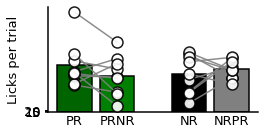

In [283]:
# Making figure for total licks - Mean per animal

f,ax=plt.subplots(figsize=(4.5,2), ncols=1, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.25)

colors_E=['Darkgreen','green','black', 'grey']

tp.barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], 
              paired= True,
              barfacecolor=colors_E,
              barfacecolor_option="individual",
              barlabels=['PR', 'PRNR', 'NR', 'NRPR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax,
              show_legend=False)






ax.set_ylabel('Licks per trial',fontsize = 13)
ax.set_yticks([5,10,15,20])
ax.set_yticklabels([5,10,15,20], fontsize = 13)


# ax.set_title('Ensure', fontsize =13)



f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\trial_licks_ensure.pdf')

In [284]:
t_value,p_value=stats.ttest_ind(ensure_PR,ensure_NR)
print('T-test (PR NR) = %f'%p_value)

t_value,p_value=stats.ttest_ind(ensure_PR,ensure_PRNR)
print('T-test(PR PRNR) = %f'%p_value)

t_value,p_value=stats.ttest_ind(ensure_NR,ensure_NRPR)
print('T-test(NR NRPR) = %f'%p_value)

t_value,p_value=stats.ttest_ind(ensure_PRNR,ensure_NRPR)
print('T-test(PRNR NRPR) = %f'%p_value)

T-test (PR NR) = 0.391040
T-test(PR PRNR) = 0.320636
T-test(NR NRPR) = 0.515354
T-test(PRNR NRPR) = 0.402730


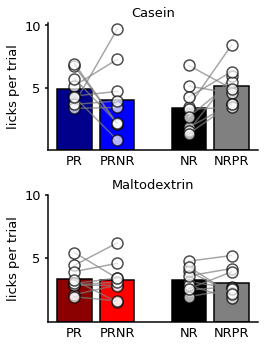

In [285]:
# Making figure for total licks - Mean per animal

f,ax=plt.subplots(figsize=(4.5,5), ncols=1, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.25)


colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']

ax[0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0],barfacecolor= colors_C)
ax[1] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[1],barfacecolor= colors_M)



ax[0].set_ylabel('licks per trial',fontsize = 13)
ax[0].set_yticks([5,10])
ax[0].set_yticklabels([5,10], fontsize = 13)

ax[1].set_ylabel('licks per trial',fontsize = 13)
ax[1].set_yticks([5,10])
ax[1].set_yticklabels([5,10], fontsize = 13)


ax[0].set_title('Casein', fontsize =13)
ax[1].set_title('Maltodextrin', fontsize =13)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\trial_licks_cm.png')

In [286]:
print('Total Licks')
print('PR_C ',np.mean(cas_PR), '-',np.std(cas_PR, ddof=1) / np.sqrt(np.size(cas_PR)))
print('NR_C ',np.mean(cas_NR), '-',np.std(cas_NR, ddof=1) / np.sqrt(np.size(cas_NR)))
print('PR_M', np.mean(malt_PR), '-', np.std(malt_PR, ddof=1) / np.sqrt(np.size(malt_PR)))
print('NR_M', np.mean(malt_NR), '-', np.std(malt_NR, ddof=1) / np.sqrt(np.size(malt_NR)))

t_value,p_value=stats.ttest_ind(cas_PR,cas_NR)
print('T-test (PR NR_C) = %f'%p_value)

t_value,p_value=stats.ttest_ind(malt_PR,malt_NR)
print('T-test (PR NR_M) = %f'%p_value)

t_value,p_value=stats.ttest_ind(malt_PR,cas_PR)
print('T-test(PR C_M) = %f'%p_value)

t_value,p_value=stats.ttest_ind(malt_NR,cas_NR)
print('T-test(NR C_M) = %f'%p_value)


t_value,p_value=stats.ttest_ind(cas_PRNR,cas_NRPR)
print('T-test (PRNR NRPR_C) = %f'%p_value)
t_value,p_value=stats.ttest_ind(malt_PRNR,malt_NRPR)
print('T-test (PRNR NRPR_M) = %f'%p_value)


t_value,p_value=stats.ttest_ind(malt_NRPR,cas_NRPR)
print('T-test(NRPR C_M) = %f'%p_value)
t_value,p_value=stats.ttest_ind(malt_PRNR,cas_PRNR)
print('T-test(PRNR C_M) = %f'%p_value)

Total Licks
PR_C  4.878925414291268 - 0.44624258236940745
NR_C  3.36439797659168 - 0.600871840654109
PR_M 3.329649218466791 - 0.37111363722219587
NR_M 3.3024536197615544 - 0.3089295958176987
T-test (PR NR_C) = 0.060051
T-test (PR NR_M) = 0.955784
T-test(PR C_M) = 0.016793
T-test(NR C_M) = 0.928088
T-test (PRNR NRPR_C) = 0.314747
T-test (PRNR NRPR_M) = 0.698864
T-test(NRPR C_M) = 0.005196
T-test(PRNR C_M) = 0.499879


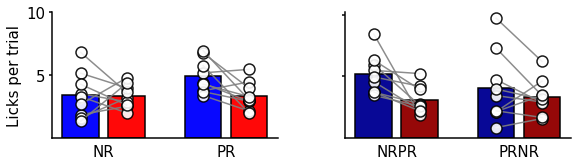

In [287]:
# Figure NR- cas/malt - PR- cas/malt 

f,ax=plt.subplots(figsize=(9,3), ncols=2, sharey=False)
f.subplots_adjust(wspace=0.3, bottom=0.3, left=0.1)

colors_1=['#0808FF','#FF0808','#0808FF','#FF0808']
colors_2=['#080896','#960808','#080896','#960808']





tp.barscatter([[cas_NR,malt_NR],[cas_PR,malt_PR]], 
              paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[0],
              grouplabel=['NR','PR'],
              show_legend=False)




tp.barscatter([[cas_NRPR,malt_NRPR],[cas_PRNR,malt_PRNR]], 
              paired= True,
              barfacecolor=colors_2,
              barfacecolor_option="individual",
              fontsize = 15,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax[1],
              grouplabel=['NRPR','PRNR'],
              show_legend=False)


ax[0].set_ylabel('Licks per trial',fontsize = 15)
ax[0].set_yticks([5,10])
ax[0].set_yticklabels([5,10], fontsize = 15)


ax[1].set_yticks([5,10])
ax[1].set_yticklabels([])



colors = {'Casein':'#080896', 'Maltodextrin':'#960808'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),0.5,0.5, color=colors[label]) for label in labels]
# ax[0].legend(handles, labels, fontsize=13, frameon=False)



# f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_3.png')

## Preference for casein - total number of licks

In [288]:

#Preference for PR 
pref_PR=[]
for cas in cas_PR:
    pref_temp=[]
    for malt in malt_PR: 
        pref_temp=(cas/(cas+malt))
    pref_PR.append(pref_temp)
    
pref_PR  

# Preference for NR 

pref_NR=[]
for cas in cas_NR:
    pref_temp=[]
    for malt in malt_NR: 
        pref_temp=(cas/(cas+malt))
    pref_NR.append(pref_temp)
    
pref_NR  

# Preference for PRNR 

pref_PRNR=[]
for cas in cas_PRNR:
    pref_temp=[]
    for malt in malt_PRNR: 
        pref_temp=(cas/(cas+malt))
    pref_PRNR.append(pref_temp)
    
pref_PRNR  


# Preference for NRPR 

pref_NRPR=[]
for cas in cas_NRPR:
    pref_temp=[]
    for malt in malt_NRPR: 
        pref_temp=(cas/(cas+malt))
    pref_NRPR.append(pref_temp)
    


Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.
Could not space all sets of points.


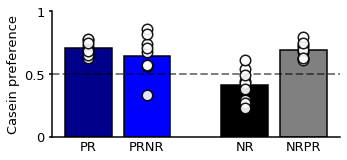

In [289]:

f,ax=plt.subplots(figsize=(5,3), ncols=1, sharey=False)
f.subplots_adjust(wspace=0.3, bottom=0.3, left=0.1)

colors_1=['darkblue','blue','black','grey']






tp.barscatter([[pref_PR,pref_PRNR],[pref_NR,pref_NRPR]], 
#               paired= True,
              barfacecolor=colors_1,
              barfacecolor_option="individual",
              barlabels=['PR', 'PRNR', 'NR', 'NRPR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax,
              show_legend=False)


ax.set_ylabel('Casein preference',fontsize = 13)
ax.set_yticks([0,0.5,1])
ax.set_yticklabels([0,0.5,1], fontsize = 13)

ax.axhline(0.5, color='black', alpha=0.5, linewidth=2, linestyle='--')


### Stats - casein preference

In [290]:
# paried t-test: 
stats_PR_PRNR=stats.ttest_ind(pref_PR, pref_PRNR)
print('PR_PRNR',stats_PR_PRNR)

stats_NR_NRPR=stats.ttest_ind(pref_NR, pref_NRPR)
print('NR_NRPR',stats_NR_NRPR)

stats_NR_PR=stats.ttest_ind(pref_PR,pref_NR)
print('NR_PR',stats_NR_PR)

stats_NRPR_PRNR=stats.ttest_ind(pref_NRPR, pref_PRNR)
print('NRPR_PRNR',stats_NRPR_PRNR)



PR_PRNR Ttest_indResult(statistic=1.0032890238966916, pvalue=0.33065429572861493)
NR_NRPR Ttest_indResult(statistic=-5.922765062957176, pvalue=2.1441797358276828e-05)
NR_PR Ttest_indResult(statistic=6.267857445175476, pvalue=1.1218817329702435e-05)
NRPR_PRNR Ttest_indResult(statistic=0.7958485151350393, pvalue=0.43776892009203583)


## % of hit trials

In [37]:
ensure_PR,ensure_PRNR,ensure_NR,ensure_NRPR= get_grouped_data(all_data, 'Ensure', '% hit')
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', '% hit')
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', '% hit')

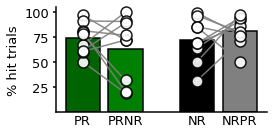

In [38]:
# Figure % hit trial - mean per animal

f,ax=plt.subplots(figsize=(4.5,2), ncols=1, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.25)

colors_E=['Darkgreen','green','black', 'grey']

tp.barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], 
              paired= True,
              barfacecolor=colors_E,
              barfacecolor_option="individual",
              barlabels=['PR', 'PRNR', 'NR', 'NRPR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax,
              show_legend=False)






ax.set_ylabel('% hit trials',fontsize = 13)
ax.set_yticks([25,50,75,100])
ax.set_yticklabels([25,50,75,100], fontsize = 13)


# ax.set_title('Ensure', fontsize =13)



f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hit_%_ensure.pdf')

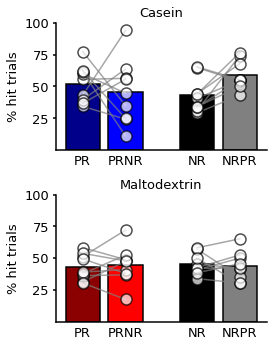

In [39]:
# Making figure for total licks - Mean per animal

f,ax=plt.subplots(figsize=(4.5,5), ncols=1, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.25)


colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']

ax[0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0],barfacecolor= colors_C)
ax[1] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[1],barfacecolor= colors_M)



ax[0].set_ylabel('% hit trials',fontsize = 13)
ax[0].set_yticks([25,50,75,100])
ax[0].set_yticklabels([25,50,75,100], fontsize = 13)

ax[1].set_ylabel('% hit trials',fontsize = 13)
ax[1].set_yticks([25,50,75,100])
ax[1].set_yticklabels([25,50,75,100], fontsize = 13)


ax[0].set_title('Casein', fontsize =13)
ax[1].set_title('Maltodextrin', fontsize =13)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hit_%_cm.pdf')



### % hit trials binned grouped by session

In [40]:
def group_hit_binned(diet, solution, session):
    bin1=[]
    bin2=[]
    bin3=[]
    bin4=[]

    for key in all_data.keys():
        d=all_data[key]
        if d['solution']== solution and d['diet'] == diet and d['session'] == session: 
            bin1.append(d['hit 1'])
            bin2.append(d['hit 2'])
            bin3.append(d['hit 3'])
            bin4.append(d['hit 4'])
        


    b1_m=np.nanmean(bin1)
    b1_E=np.nanstd(bin1, ddof=1) / np.sqrt(np.size(bin1))
    b2_m=np.nanmean(bin2)
    b2_E=np.nanstd(bin2, ddof=1) / np.sqrt(np.size(bin2))
    b3_m=np.nanmean(bin3)
    b3_E=np.nanstd(bin3, ddof=1) / np.sqrt(np.size(bin3))
    b4_m=np.nanmean(bin4)
    b4_E=np.nanstd(bin4, ddof=1) / np.sqrt(np.size(bin4))
    
    mean=[b1_m,b2_m,b3_m,b4_m]
    error=[b1_E,b2_E,b3_E,b4_E]
    
    return mean, error



In [41]:
# Casein PR 
Cas_PR_S1_m, Cas_PR_S1_E= group_hit_binned('PR','Cas','S1')
Cas_PR_S2_m, Cas_PR_S2_E= group_hit_binned('PR','Cas','S2')
Cas_PR_S3_m, Cas_PR_S3_E= group_hit_binned('PR','Cas','S3')

# maltodextrin PR 
malt_PR_S1_m, malt_PR_S1_E= group_hit_binned('PR','Malt.','S1')
malt_PR_S2_m, malt_PR_S2_E= group_hit_binned('PR','Malt.','S2')
malt_PR_S3_m, malt_PR_S3_E= group_hit_binned('PR','Malt.','S3')

# Casein PRNR 
Cas_PRNR_S1_m, Cas_PRNR_S1_E= group_hit_binned('PRNR','Cas','S1')
Cas_PRNR_S2_m, Cas_PRNR_S2_E= group_hit_binned('PRNR','Cas','S2')
Cas_PRNR_S3_m, Cas_PRNR_S3_E= group_hit_binned('PRNR','Cas','S3')

# maltodextrin PRNR 
malt_PRNR_S1_m, malt_PRNR_S1_E= group_hit_binned('PRNR','Malt.','S1')
malt_PRNR_S2_m, malt_PRNR_S2_E= group_hit_binned('PRNR','Malt.','S2')
malt_PRNR_S3_m, malt_PRNR_S3_E= group_hit_binned('PRNR','Malt.','S3')

In [42]:
# Casein NR 
Cas_NR_S1_m, Cas_NR_S1_E= group_hit_binned('NR','Cas','S1')
Cas_NR_S2_m, Cas_NR_S2_E= group_hit_binned('NR','Cas','S2')
Cas_NR_S3_m, Cas_NR_S3_E= group_hit_binned('NR','Cas','S3')

# maltodextrin NR 
malt_NR_S1_m, malt_NR_S1_E= group_hit_binned('NR','Malt.','S1')
malt_NR_S2_m, malt_NR_S2_E= group_hit_binned('NR','Malt.','S2')
malt_NR_S3_m, malt_NR_S3_E= group_hit_binned('NR','Malt.','S3')

# Casein NRPR 
Cas_NRPR_S1_m, Cas_NRPR_S1_E= group_hit_binned('NRPR','Cas','S1')
Cas_NRPR_S2_m, Cas_NRPR_S2_E= group_hit_binned('NRPR','Cas','S2')
Cas_NRPR_S3_m, Cas_NRPR_S3_E= group_hit_binned('NRPR','Cas','S3')

# maltodextrin NRPR 
malt_NRPR_S1_m, malt_NRPR_S1_E= group_hit_binned('NRPR','Malt.','S1')
malt_NRPR_S2_m, malt_NRPR_S2_E= group_hit_binned('NRPR','Malt.','S2')
malt_NRPR_S3_m, malt_NRPR_S3_E= group_hit_binned('NRPR','Malt.','S3')

### Figure % hit trial per session

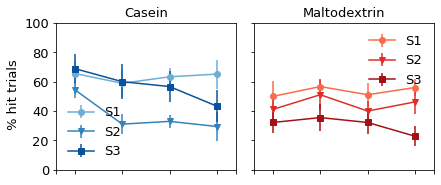

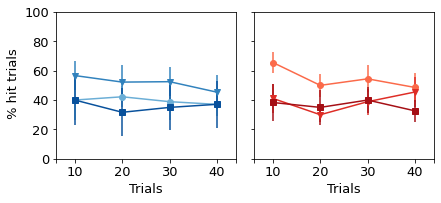

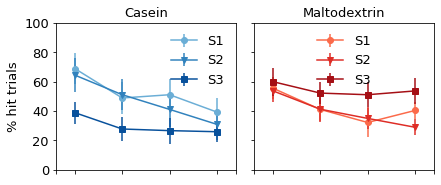

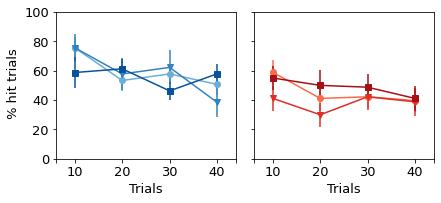

In [43]:
#PR - PRNR

f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]

colors_C=['#0808FF','#080896','#08083C','#FF0808','#960808','#420808']

ax1.errorbar(x, Cas_PR_S1_m, yerr=Cas_PR_S1_E, fmt="-o", color='#6baed6')
ax1.errorbar(x, Cas_PR_S2_m, yerr=Cas_PR_S2_E, fmt="-v", color='#3182bd')
ax1.errorbar(x, Cas_PR_S3_m, yerr=Cas_PR_S3_E, fmt="-s", color='#08519c')


ax2.errorbar(x, malt_PR_S1_m, yerr=malt_PR_S1_E, fmt="-o", color='#fb6a4a')
ax2.errorbar(x, malt_PR_S2_m, yerr=malt_PR_S2_E, fmt="-v", color='#de2d26')
ax2.errorbar(x, malt_PR_S3_m, yerr=malt_PR_S3_E, fmt="-s", color='#a50f15')

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel(' % hit trials',fontsize = 13)



ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0, 20,40,60,80,100],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f2, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_PRNR_S1_m, yerr=Cas_PRNR_S1_E, fmt="-o", color='#6baed6')
ax1.errorbar(x, Cas_PRNR_S2_m, yerr=Cas_PRNR_S2_E, fmt="-v", color='#3182bd')
ax1.errorbar(x, Cas_PRNR_S3_m, yerr=Cas_PRNR_S3_E, fmt="-s", color='#08519c')


ax2.errorbar(x, malt_PRNR_S1_m, yerr=malt_PRNR_S1_E, fmt="-o", color='#fb6a4a')
ax2.errorbar(x, malt_PRNR_S2_m, yerr=malt_PRNR_S2_E, fmt="-v", color='#de2d26')
ax2.errorbar(x, malt_PRNR_S3_m, yerr=malt_PRNR_S3_E, fmt="-s", color='#a50f15')



ax1.set_ylabel(' % hit trials',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,20,40,60,80,100],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hitsPR.pdf')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hitsPRNR.pdf')


#------------------------------------------------------------------------
#NR- NRPR

f3, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f3.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]

colors_C=['#0808FF','#080896','#08083C','#FF0808','#960808','#420808']

ax1.errorbar(x, Cas_NR_S1_m, yerr=Cas_NR_S1_E, fmt="-o", color='#6baed6')
ax1.errorbar(x, Cas_NR_S2_m, yerr=Cas_NR_S2_E, fmt="-v", color='#3182bd')
ax1.errorbar(x, Cas_NR_S3_m, yerr=Cas_NR_S3_E, fmt="-s", color='#08519c')


ax2.errorbar(x, malt_NR_S1_m, yerr=malt_NR_S1_E, fmt="-o", color='#fb6a4a')
ax2.errorbar(x, malt_NR_S2_m, yerr=malt_NR_S2_E, fmt="-v", color='#de2d26')
ax2.errorbar(x, malt_NR_S3_m, yerr=malt_NR_S3_E, fmt="-s", color='#a50f15')

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('% hit trials',fontsize = 13)



ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,20,40,60,80,100],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f4, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f4.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_NRPR_S1_m, yerr=Cas_NRPR_S1_E, fmt="-o", color='#6baed6')
ax1.errorbar(x, Cas_NRPR_S2_m, yerr=Cas_NRPR_S2_E, fmt="-v", color='#3182bd')
ax1.errorbar(x, Cas_NRPR_S3_m, yerr=Cas_NRPR_S3_E, fmt="-s", color='#08519c')


ax2.errorbar(x, malt_NRPR_S1_m, yerr=malt_NRPR_S1_E, fmt="-o", color='#fb6a4a')
ax2.errorbar(x, malt_NRPR_S2_m, yerr=malt_NRPR_S2_E, fmt="-v", color='#de2d26')
ax2.errorbar(x, malt_NRPR_S3_m, yerr=malt_NRPR_S3_E, fmt="-s", color='#a50f15')



ax1.set_ylabel(' % hit trials',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,20,40,60,80,100],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


f3.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hitsNR.pdf')
f4.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hitsNRPR.pdf')

In [44]:
cas_PR_S1,cas_PRNR_S1,cas_NR_S1,cas_NRPR_S1 = grouped_by_session(all_data, 'Cas','S1', '% hit')
cas_PR_S2,cas_PRNR_S2,cas_NR_S2,cas_NRPR_S2 = grouped_by_session(all_data, 'Cas','S2', '% hit')
cas_PR_S3,cas_PRNR_S3,cas_NR_S3,cas_NRPR_S3 = grouped_by_session(all_data, 'Cas','S3', '% hit')

malt_PR_S1,malt_PRNR_S1,malt_NR_S1,malt_NRPR_S1 = grouped_by_session(all_data, 'Malt.','S1', '% hit')
malt_PR_S2,malt_PRNR_S2,malt_NR_S2,malt_NRPR_S2 = grouped_by_session(all_data, 'Malt.','S2', '% hit')
malt_PR_S3,malt_PRNR_S3,malt_NR_S3,malt_NRPR_S3 = grouped_by_session(all_data, 'Malt.','S3', '% hit')

C:\Users\mko102\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


ValueError: x and y must have same first dimension, but have shapes (3,) and (9,)

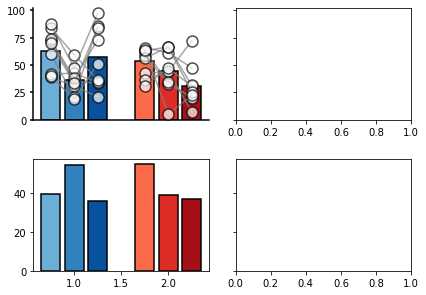

In [45]:
f,ax=plt.subplots(figsize=(7,5), ncols=2, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.15)

colors_C=['#6baed6','#3182bd','#08519c','#fb6a4a','#de2d26','#a50f15']


ax[0,0]= make_barscatter([[cas_PR_S1,cas_PR_S2,cas_PR_S3],[malt_PR_S1,malt_PR_S2,malt_PR_S3]], ax=ax[0,0], barfacecolor=colors_C)
ax[1,0]= make_barscatter([[cas_PRNR_S1,cas_PRNR_S2,cas_PRNR_S3],[malt_PRNR_S1,malt_PRNR_S2,malt_PRNR_S3]], ax=ax[1,0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,1]= make_barscatter([[cas_NR_S1,cas_NR_S2,cas_NR_S3],[malt_NR_S1,malt_NR_S2,malt_NR_S3]], ax=ax[0,1], barfacecolor=colors_C)
ax[1,1]= make_barscatter([[cas_NRPR_S1,cas_NRPR_S2,cas_NRPR_S3],[malt_NRPR_S1,malt_NRPR_S2,malt_NRPR_S3]], ax=ax[1,1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,0].set_ylabel('% hit trials',fontsize = 13)
ax[0,0].set_yticks([0,25,50,75,100])
ax[0,1].set_yticks([0,25,50,75,100])
ax[0,0].set_yticklabels([0,25,50,75,100], fontsize = 13)

ax[1,0].set_ylabel('% hit trials',fontsize = 13)
ax[1,0].set_yticks([0,25,50,75,100])
ax[1,1].set_yticks([0,25,50,75,100])
ax[1,0].set_yticklabels([0,25,50,75,100], fontsize = 13)

ax[0,0].set_title('PR',fontsize=13)
ax[0,1].set_title('NR',fontsize=13)
ax[1,0].set_title('PRNR',fontsize=13)
ax[1,1].set_title('NRPR',fontsize=13)






f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hit_%_session_cm.pdf')

### % hit trials binned grouped by session Ensure

In [ ]:
# Ensure PR 
Ensure_PR_S1_m, Ensure_PR_S1_E= group_hit_binned('PR','Ensure','S1')
Ensure_PR_S2_m, Ensure_PR_S2_E= group_hit_binned('PR','Ensure','S2')
Ensure_PR_S3_m, Ensure_PR_S3_E= group_hit_binned('PR','Ensure','S3')

# Ensure NR
Ensure_NR_S1_m, Ensure_NR_S1_E= group_hit_binned('NR','Ensure','S1')
Ensure_NR_S2_m, Ensure_NR_S2_E= group_hit_binned('NR','Ensure','S2')
Ensure_NR_S3_m, Ensure_NR_S3_E= group_hit_binned('NR','Ensure','S3')

# Casein PRNR 
Ensure_PRNR_S1_m, Ensure_PRNR_S1_E= group_hit_binned('PRNR','Ensure','S1')
Ensure_PRNR_S2_m, Ensure_PRNR_S2_E= group_hit_binned('PRNR','Ensure','S2')
Ensure_PRNR_S3_m, Ensure_PRNR_S3_E= group_hit_binned('PRNR','Ensure','S3')

# maltodextrin PRNR 
Ensure_NRPR_S1_m, Ensure_NRPR_S1_E= group_hit_binned('NRPR','Ensure','S1')
Ensure_NRPR_S2_m, Ensure_NRPR_S2_E= group_hit_binned('NRPR','Ensure','S2')
Ensure_NRPR_S3_m, Ensure_NRPR_S3_E= group_hit_binned('NRPR','Ensure','S3')

In [ ]:
f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]

#08FA08
#089608
#083C08

ax1.errorbar(x, Ensure_PR_S1_m, yerr=Ensure_PR_S1_E, fmt="-o", color='#bae4b3')
ax1.errorbar(x, Ensure_PR_S2_m, yerr=Ensure_PR_S2_E, fmt="-v", color='#74c476')
ax1.errorbar(x, Ensure_PR_S3_m, yerr=Ensure_PR_S3_E, fmt="-s", color='#238b45')


ax2.errorbar(x, Ensure_PRNR_S1_m, yerr=Ensure_PRNR_S1_E, fmt="-o", color='#bae4b3')
ax2.errorbar(x, Ensure_PRNR_S2_m, yerr=Ensure_PRNR_S2_E, fmt="-v", color='#74c476')
ax2.errorbar(x, Ensure_PRNR_S3_m, yerr=Ensure_PRNR_S3_E, fmt="-s", color='#238b45')

ax1.set_title('PR',fontsize=13)
ax2.set_title('PRNR',fontsize=13)

ax1.set_ylabel(' \n % hit trials',fontsize = 13)



ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,20,40,60,80,100],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)






f2, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Ensure_NR_S1_m, yerr=Ensure_NR_S1_E, fmt="-o", color='#bae4b3')
ax1.errorbar(x, Ensure_NR_S2_m, yerr=Ensure_NR_S2_E, fmt="-v", color='#74c476')
ax1.errorbar(x, Ensure_NR_S3_m, yerr=Ensure_NR_S3_E, fmt="-s", color='#238b45')


ax2.errorbar(x, Ensure_NRPR_S1_m, yerr=Ensure_NRPR_S1_E, fmt="-o", color='#bae4b3')
ax2.errorbar(x, Ensure_NRPR_S2_m, yerr=Ensure_NRPR_S2_E, fmt="-v", color='#74c476')
ax2.errorbar(x, Ensure_NRPR_S3_m, yerr=Ensure_NRPR_S3_E, fmt="-s", color='#238b45')

ax1.set_title('NR',fontsize=13)
ax2.set_title('NRPR',fontsize=13)

ax1.set_ylabel(' \n %hit trials',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,20,40,60,80,100],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hitsPR_Ensure.pdf')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hitsNR_Ensure.pdf')


In [ ]:
ensure_PR_S1,ensure_PRNR_S1,ensure_NR_S1,ensure_NRPR_S1 = grouped_by_session(all_data, 'Ensure','S1', '% hit')
ensure_PR_S2,ensure_PRNR_S2,ensure_NR_S2,ensure_NRPR_S2 = grouped_by_session(all_data, 'Ensure','S2', '% hit')
ensure_PR_S3,ensure_PRNR_S3,ensure_NR_S3,ensure_NRPR_S3 = grouped_by_session(all_data, 'Ensure','S3', '% hit')

In [ ]:
f,ax=plt.subplots(figsize=(7,2), ncols=2, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.15)

colors_C=['#bae4b3','#74c476','#238b45','#bae4b3','#74c476','#238b45']



ax[0]= make_barscatter([[ensure_PR_S1,ensure_PR_S2,ensure_PR_S3],[ensure_PRNR_S1,ensure_PRNR_S2,ensure_PRNR_S3]], ax=ax[0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])
ax[1]= make_barscatter([[ensure_NR_S1,ensure_NR_S2,ensure_NR_S3],[ensure_NRPR_S1,ensure_NRPR_S2,ensure_NRPR_S3]], ax=ax[1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])







ax[0].set_ylabel('% hit trials',fontsize = 13)
ax[0].set_yticks([0,25,50,75,100])
ax[1].set_yticks([0,25,50,75,100])
ax[0].set_yticklabels([0,25,50,75,100], fontsize = 13)




f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hit_%_session_Ensure.pdf')



### % hit trials binned grouped by session Baseline

In [ ]:
# Ensure PR 
Baseline_PR_S1_m, Baseline_PR_S1_E= group_hit_binned('PR','Baseline','S1')
Baseline_PR_S2_m, Baseline_PR_S2_E= group_hit_binned('PR','Baseline','S2')
Baseline_PR_S3_m, Baseline_PR_S3_E= group_hit_binned('PR','Baseline','S3')

# Ensure NR
Baseline_NR_S1_m, Baseline_NR_S1_E= group_hit_binned('NR','Baseline','S1')
Baseline_NR_S2_m, Baseline_NR_S2_E= group_hit_binned('NR','Baseline','S2')
Baseline_NR_S3_m, Baseline_NR_S3_E= group_hit_binned('NR','Baseline','S3')



In [ ]:
f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]




ax1.errorbar(x, Baseline_PR_S1_m, yerr=Baseline_PR_S1_E, fmt="-o", color='#fee6ce')
ax1.errorbar(x, Baseline_PR_S2_m, yerr=Baseline_PR_S2_E, fmt="-v", color='#fdae6b')
ax1.errorbar(x, Baseline_PR_S3_m, yerr=Baseline_PR_S3_E, fmt="-s", color='#e6550d')


ax2.errorbar(x, Baseline_NR_S1_m, yerr=Baseline_NR_S1_E, fmt="-o", color='#fee6ce')
ax2.errorbar(x, Baseline_NR_S2_m, yerr=Baseline_NR_S2_E, fmt="-v", color='#fdae6b')
ax2.errorbar(x, Baseline_NR_S3_m, yerr=Baseline_NR_S3_E, fmt="-s", color='#e6550d')

ax1.set_title('PR',fontsize=13)
ax2.set_title('NR',fontsize=13)

ax1.set_ylabel(' \n % hit trials',fontsize = 13)





ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)


ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,20,40,60,80,100],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)

f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hits_Baseline.pdf')



In [ ]:
PR_S1=[]
NR_S1=[]

PR_S2=[]
NR_S2=[]

PR_S3=[]
NR_S3=[]
    
for key in all_data.keys():
        d=all_data[key]
        if d['solution']== 'Baseline' and d['diet'] == 'PR' and d['session'] == 'S1': 
            PR_S1.append(np.mean(d['% hit']))
        elif d['solution']== 'Baseline' and d['diet'] == 'NR' and d['session'] == 'S1': 
            NR_S1.append(np.mean(d['% hit']))
            
        elif d['solution']== 'Baseline' and d['diet'] == 'PR' and d['session'] == 'S2': 
            PR_S2.append(np.mean(d['% hit']))
        elif d['solution']== 'Baseline' and d['diet'] == 'NR' and d['session'] == 'S2': 
            NR_S2.append(np.mean(d['% hit']))
            
        elif d['solution']== 'Baseline' and d['diet'] == 'PR' and d['session'] == 'S3': 
            PR_S3.append(np.mean(d['% hit']))
        elif d['solution']== 'Baseline' and d['diet'] == 'NR' and d['session'] == 'S3': 
            NR_S3.append(np.mean(d['% hit']))
            
            
            


In [ ]:
f,ax=plt.subplots(figsize=(4.5,2), ncols=2, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.25)

colors_C=['#fee6ce','#fdae6b','#e6550d']



ax[0]= make_barscatter([PR_S1,PR_S2,PR_S3], ax=ax[0], barfacecolor=colors_C,barlabels=['1','2','3'])
ax[1]= make_barscatter([NR_S1,NR_S2,NR_S3], ax=ax[1], barfacecolor=colors_C,barlabels=['1','2','3'])




ax[0].set_ylabel('# of licks \n per sesseion',fontsize = 13)
ax[0].set_yticks([0,25,50,75,100])
ax[1].set_yticks([0,25,50,75,100])
ax[0].set_yticklabels([0,25,50,75,100], fontsize = 13)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hit_session_Baseline.pdf')

In [ ]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['% hit'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['% hit'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))



In [ ]:
# Making figure for total licks - Mean per animal

f,ax=plt.subplots(figsize=(3.5,2), ncols=1, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.3)

colors_B=['orange','black']


ax= make_barscatter([[baseline_PR],[baseline_NR]], ax=ax, barfacecolor=colors_B, barlabels=['PR','NR'])


ax.set_ylabel('% hit trials',fontsize = 13)
ax.set_yticks([25,50,75,100])
ax.set_yticklabels([25,50,75,100], fontsize = 13)




f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\hit_trials_baseline.pdf')

## Latency to first lick

## latency session

In [ ]:
def get_grouped_latencybin(diet,solution, session):

    bin1=[]
    bin2=[]
    bin3=[]
    bin4=[]

    for key in all_data.keys():
        d=all_data[key]
        if d['solution']== solution and d['diet'] == diet and d['session'] == session and len(d['pump_fn']) > 30: 
            if d['latency1'] > 0:
                bin1.append(d['latency1'])
            if d['latency2'] > 0:
                bin2.append(d['latency2'])
            if d['latency3'] > 0:
                bin3.append(d['latency3'])
            if d['latency4'] > 0:
                bin4.append(d['latency4'])
        


    b1_m=np.mean(bin1)
    b1_E=np.std(bin1, ddof=1) / np.sqrt(np.size(bin1))
    b2_m=np.mean(bin2)
    b2_E=np.std(bin2, ddof=1) / np.sqrt(np.size(bin2))
    b3_m=np.mean(bin3)
    b3_E=np.std(bin3, ddof=1) / np.sqrt(np.size(bin3))
    b4_m=np.mean(bin4)
    b4_E=np.std(bin4, ddof=1) / np.sqrt(np.size(bin4))
    
    mean=[b1_m,b2_m,b3_m,b4_m]
    error=[b1_E,b2_E,b3_E,b4_E]
    
    
    return mean,error
    

In [ ]:
# Casein PR 
Cas_PR_S1_m, Cas_PR_S1_E= get_grouped_latencybin('PR','Cas','S1')
Cas_PR_S2_m, Cas_PR_S2_E= get_grouped_latencybin('PR','Cas','S2')
Cas_PR_S3_m, Cas_PR_S3_E= get_grouped_latencybin('PR','Cas','S3')

# maltodextrin PR 
malt_PR_S1_m, malt_PR_S1_E= get_grouped_latencybin('PR','Malt.','S1')
malt_PR_S2_m, malt_PR_S2_E= get_grouped_latencybin('PR','Malt.','S2')
malt_PR_S3_m, malt_PR_S3_E= get_grouped_latencybin('PR','Malt.','S3')

# Casein PRNR 
Cas_PRNR_S1_m, Cas_PRNR_S1_E= get_grouped_latencybin('PRNR','Cas','S1')
Cas_PRNR_S2_m, Cas_PRNR_S2_E= get_grouped_latencybin('PRNR','Cas','S2')
Cas_PRNR_S3_m, Cas_PRNR_S3_E= get_grouped_latencybin('PRNR','Cas','S3')

# maltodextrin PRNR 
malt_PRNR_S1_m, malt_PRNR_S1_E= get_grouped_latencybin('PRNR','Malt.','S1')
malt_PRNR_S2_m, malt_PRNR_S2_E= get_grouped_latencybin('PRNR','Malt.','S2')
malt_PRNR_S3_m, malt_PRNR_S3_E= get_grouped_latencybin('PRNR','Malt.','S3')

In [ ]:
# Casein NR 
Cas_NR_S1_m, Cas_NR_S1_E= get_grouped_latencybin('NR','Cas','S1')
Cas_NR_S2_m, Cas_NR_S2_E= get_grouped_latencybin('NR','Cas','S2')
Cas_NR_S3_m, Cas_NR_S3_E= get_grouped_latencybin('NR','Cas','S3')

# maltodextrin NR 
malt_NR_S1_m, malt_NR_S1_E= get_grouped_latencybin('NR','Malt.','S1')
malt_NR_S2_m, malt_NR_S2_E= get_grouped_latencybin('NR','Malt.','S2')
malt_NR_S3_m, malt_NR_S3_E= get_grouped_latencybin('NR','Malt.','S3')

# Casein NRPR 
Cas_NRPR_S1_m, Cas_NRPR_S1_E= get_grouped_latencybin('NRPR','Cas','S1')
Cas_NRPR_S2_m, Cas_NRPR_S2_E= get_grouped_latencybin('NRPR','Cas','S2')
Cas_NRPR_S3_m, Cas_NRPR_S3_E= get_grouped_latencybin('NRPR','Cas','S3')

# maltodextrin NRPR 
malt_NRPR_S1_m, malt_NRPR_S1_E= get_grouped_latencybin('NRPR','Malt.','S1')
malt_NRPR_S2_m, malt_NRPR_S2_E= get_grouped_latencybin('NRPR','Malt.','S2')
malt_NRPR_S3_m, malt_NRPR_S3_E= get_grouped_latencybin('NRPR','Malt.','S3')

In [ ]:
f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]


colors_C=['#0808FF','#080896','#08083C','#FF0808','#960808','#420808']

ax1.errorbar(x, Cas_PR_S1_m, yerr=Cas_PR_S1_E, fmt="-o", color='#6baed6')
ax1.errorbar(x, Cas_PR_S2_m, yerr=Cas_PR_S2_E, fmt="-v", color='#3182bd')
ax1.errorbar(x, Cas_PR_S3_m, yerr=Cas_PR_S3_E, fmt="-s", color='#08519c')


ax2.errorbar(x, malt_PR_S1_m, yerr=malt_PR_S1_E, fmt="-o", color='#fb6a4a')
ax2.errorbar(x, malt_PR_S2_m, yerr=malt_PR_S2_E, fmt="-v", color='#de2d26')
ax2.errorbar(x, malt_PR_S3_m, yerr=malt_PR_S3_E, fmt="-s", color='#a50f15')

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Latency (sec)',fontsize = 13)



ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f2, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_PRNR_S1_m, yerr=Cas_PRNR_S1_E, fmt="-o", color='#6baed6')
ax1.errorbar(x, Cas_PRNR_S2_m, yerr=Cas_PRNR_S2_E, fmt="-v", color='#3182bd')
ax1.errorbar(x, Cas_PRNR_S3_m, yerr=Cas_PRNR_S3_E, fmt="-s", color='#08519c')


ax2.errorbar(x, malt_PRNR_S1_m, yerr=malt_PRNR_S1_E, fmt="-o", color='#fb6a4a')
ax2.errorbar(x, malt_PRNR_S2_m, yerr=malt_PRNR_S2_E, fmt="-v", color='#de2d26')
ax2.errorbar(x, malt_PRNR_S3_m, yerr=malt_PRNR_S3_E, fmt="-s", color='#a50f15')



ax1.set_ylabel('Latency (sec)',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\LatencyPR.pdf')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latencyPRNR.pdf')


#---------------------------------------------------------------------------------------------------------------------------------------------------------------------
#NR - NRPR

f3, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f3.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]

colors_C=['#0808FF','#080896','#08083C','#FF0808','#960808','#420808']

ax1.errorbar(x, Cas_NR_S1_m, yerr=Cas_NR_S1_E, fmt="-o", color='#6baed6')
ax1.errorbar(x, Cas_NR_S2_m, yerr=Cas_NR_S2_E, fmt="-v", color='#3182bd')
ax1.errorbar(x, Cas_NR_S3_m, yerr=Cas_NR_S3_E, fmt="-s", color='#08519c')


ax2.errorbar(x, malt_NR_S1_m, yerr=malt_NR_S1_E, fmt="-o", color='#fb6a4a')
ax2.errorbar(x, malt_NR_S2_m, yerr=malt_NR_S2_E, fmt="-v", color='#de2d26')
ax2.errorbar(x, malt_NR_S3_m, yerr=malt_NR_S3_E, fmt="-s", color='#a50f15')

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Latency (sec)',fontsize = 13)



ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f4, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f4.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Cas_NRPR_S1_m, yerr=Cas_NRPR_S1_E, fmt="-o", color='#6baed6')
ax1.errorbar(x, Cas_NRPR_S2_m, yerr=Cas_NRPR_S2_E, fmt="-v", color='#3182bd')
ax1.errorbar(x, Cas_NRPR_S3_m, yerr=Cas_NRPR_S3_E, fmt="-s", color='#08519c')


ax2.errorbar(x, malt_NRPR_S1_m, yerr=malt_NRPR_S1_E, fmt="-o", color='#fb6a4a')
ax2.errorbar(x, malt_NRPR_S2_m, yerr=malt_NRPR_S2_E, fmt="-v", color='#de2d26')
ax2.errorbar(x, malt_NRPR_S3_m, yerr=malt_NRPR_S3_E, fmt="-s", color='#a50f15')



ax1.set_ylabel('Latency (sec)',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


f3.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\LatencyNR.pdf')
f4.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latencyNRPR.pdf')

In [ ]:
cas_PR_S1,cas_PRNR_S1,cas_NR_S1,cas_NRPR_S1 = grouped_by_session(all_data, 'Cas','S1', 'latency')
cas_PR_S2,cas_PRNR_S2,cas_NR_S2,cas_NRPR_S2 = grouped_by_session(all_data, 'Cas','S2', 'latency')
cas_PR_S3,cas_PRNR_S3,cas_NR_S3,cas_NRPR_S3 = grouped_by_session(all_data, 'Cas','S3', 'latency')

malt_PR_S1,malt_PRNR_S1,malt_NR_S1,malt_NRPR_S1 = grouped_by_session(all_data, 'Malt.','S1', 'latency')
malt_PR_S2,malt_PRNR_S2,malt_NR_S2,malt_NRPR_S2 = grouped_by_session(all_data, 'Malt.','S2', 'latency')
malt_PR_S3,malt_PRNR_S3,malt_NR_S3,malt_NRPR_S3 = grouped_by_session(all_data, 'Malt.','S3', 'latency')

In [ ]:
f,ax=plt.subplots(figsize=(7,5), ncols=2, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.15)

colors_C=['#6baed6','#3182bd','#08519c','#fb6a4a','#de2d26','#a50f15']


ax[0,0]= make_barscatter([[cas_PR_S1,cas_PR_S2,cas_PR_S3],[malt_PR_S1,malt_PR_S2,malt_PR_S3]], ax=ax[0,0], barfacecolor=colors_C)
ax[1,0]= make_barscatter([[cas_PRNR_S1,cas_PRNR_S2,cas_PRNR_S3],[malt_PRNR_S1,malt_PRNR_S2,malt_PRNR_S3]], ax=ax[1,0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,1]= make_barscatter([[cas_NR_S1,cas_NR_S2,cas_NR_S3],[malt_NR_S1,malt_NR_S2,malt_NR_S3]], ax=ax[0,1], barfacecolor=colors_C)
ax[1,1]= make_barscatter([[cas_NRPR_S1,cas_NRPR_S2,cas_NRPR_S3],[malt_NRPR_S1,malt_NRPR_S2,malt_NRPR_S3]], ax=ax[1,1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,0].set_ylabel('Latency (sec)',fontsize = 13)
ax[0,0].set_yticks([0,20,40,60,80,100])
ax[0,1].set_yticks([0,20,40,60,80,100])
ax[0,0].set_yticklabels([0,2,4,6,8,10], fontsize = 13)

ax[1,0].set_ylabel('Latency (sec)',fontsize = 13)
ax[1,0].set_yticks([0,20,40,60,80,100])
ax[1,1].set_yticks([0,20,40,60,80,100])
ax[1,0].set_yticklabels([0,2,4,6,8,10], fontsize = 13)

ax[0,0].set_title('PR',fontsize=13)
ax[0,1].set_title('NR',fontsize=13)
ax[1,0].set_title('PRNR',fontsize=13)
ax[1,1].set_title('NRPR',fontsize=13)






f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latency_session_cm.pdf')

In [ ]:
# Casein NR 
Ensure_NR_S1_m, Ensure_NR_S1_E= get_grouped_latencybin('NR','Ensure','S1')
Ensure_NR_S2_m, Ensure_NR_S2_E= get_grouped_latencybin('NR','Ensure','S2')
Ensure_NR_S3_m, Ensure_NR_S3_E= get_grouped_latencybin('NR','Ensure','S3')

# maltodextrin NR 
Ensure_PR_S1_m, Ensure_PR_S1_E= get_grouped_latencybin('PR','Ensure','S1')
Ensure_PR_S2_m, Ensure_PR_S2_E= get_grouped_latencybin('PR','Ensure','S2')
Ensure_PR_S3_m, Ensure_PR_S3_E= get_grouped_latencybin('PR','Ensure','S3')

# Casein NRPR 
Ensure_NRPR_S1_m, Ensure_NRPR_S1_E= get_grouped_latencybin('NRPR','Ensure','S1')
Ensure_NRPR_S2_m, Ensure_NRPR_S2_E= get_grouped_latencybin('NRPR','Ensure','S2')
Ensure_NRPR_S3_m, Ensure_NRPR_S3_E= get_grouped_latencybin('NRPR','Ensure','S3')

# maltodextrin NRPR 
Ensure_PRNR_S1_m, Ensure_PRNR_S1_E= get_grouped_latencybin('PRNR','Ensure','S1')
Ensure_PRNR_S2_m, Ensure_PRNR_S2_E= get_grouped_latencybin('PRNR','Ensure','S2')
Ensure_PRNR_S3_m, Ensure_PRNR_S3_E= get_grouped_latencybin('PRNR','Ensure','S3')

In [ ]:
f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]




ax1.errorbar(x, Ensure_PR_S1_m, yerr=Ensure_PR_S1_E, fmt="-o", color='#bae4b3')
ax1.errorbar(x, Ensure_PR_S2_m, yerr=Ensure_PR_S2_E, fmt="-v", color='#74c476')
ax1.errorbar(x, Ensure_PR_S3_m, yerr=Ensure_PR_S3_E, fmt="-s", color='#238b45')


ax2.errorbar(x, Ensure_PRNR_S1_m, yerr=Ensure_PRNR_S1_E, fmt="-o", color='#bae4b3')
ax2.errorbar(x, Ensure_PRNR_S2_m, yerr=Ensure_PRNR_S2_E, fmt="-v", color='#74c476')
ax2.errorbar(x, Ensure_PRNR_S3_m, yerr=Ensure_PRNR_S3_E, fmt="-s", color='#238b45')

ax1.set_title('PR',fontsize=13)
ax2.set_title('PRNR',fontsize=13)

ax1.set_ylabel('Latency (sec)',fontsize = 13)



ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
# ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)





f2, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)
x=[1,2,3,4]


ax1.errorbar(x, Ensure_NR_S1_m, yerr=Ensure_NR_S1_E, fmt="-o", color='#bae4b3')
ax1.errorbar(x, Ensure_NR_S2_m, yerr=Ensure_NR_S2_E, fmt="-v", color='#74c476')
ax1.errorbar(x, Ensure_NR_S3_m, yerr=Ensure_NR_S3_E, fmt="-s", color='#238b45')


ax2.errorbar(x, Ensure_NRPR_S1_m, yerr=Ensure_NRPR_S1_E, fmt="-o", color='#bae4b3')
ax2.errorbar(x, Ensure_NRPR_S2_m, yerr=Ensure_NRPR_S2_E, fmt="-v", color='#74c476')
ax2.errorbar(x, Ensure_NRPR_S3_m, yerr=Ensure_NRPR_S3_E, fmt="-s", color='#238b45')

ax1.set_title('NR',fontsize=13)
ax2.set_title('NRPR',fontsize=13)

ax1.set_ylabel('Latency (sec)',fontsize = 13)

ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\LatencyPR_Ensure.pdf')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latencyPRNR_Ensure.pdf')

In [ ]:
ensure_PR_S1,ensure_PRNR_S1,ensure_NR_S1,ensure_NRPR_S1 = grouped_by_session(all_data, 'Ensure','S1', 'latency')
ensure_PR_S2,ensure_PRNR_S2,ensure_NR_S2,ensure_NRPR_S2 = grouped_by_session(all_data, 'Ensure','S2', 'latency')
ensure_PR_S3,ensure_PRNR_S3,ensure_NR_S3,ensure_NRPR_S3 = grouped_by_session(all_data, 'Ensure','S3', 'latency')




# Removing nan values from the lists 
from numpy import nan  
ensure_PRNR_S1 = [element for element in ensure_PRNR_S1 if not np.isnan(element)]
ensure_PRNR_S2 = [element for element in ensure_PRNR_S2 if not np.isnan(element)]


In [ ]:
f,ax=plt.subplots(figsize=(7,2), ncols=2, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.15)

colors_C=['#bae4b3','#74c476','#238b45','#bae4b3','#74c476','#238b45']


ax[0]= make_barscatter([[ensure_PR_S1,ensure_PR_S2,ensure_PR_S3],[ensure_PRNR_S1,ensure_PRNR_S2,ensure_PRNR_S3]], ax=ax[0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])
ax[1]= make_barscatter([[ensure_NR_S1,ensure_NR_S2,ensure_NR_S3],[ensure_NRPR_S1,ensure_NRPR_S2,ensure_NRPR_S3]], ax=ax[1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])


ax[0].set_ylabel('Latency (sec)',fontsize = 13)
ax[0].set_yticks([0,20,40,60,80,100])
ax[1].set_yticks([0,20,40,60,80,100])
ax[0].set_yticklabels([0,2,4,6,8,10], fontsize = 13)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\Latency_session_Ensure.pdf')



Latency Baseline

In [ ]:
Baseline_NR_S1_m, Baseline_NR_S1_E= get_grouped_latencybin('NR','Baseline','S1')
Baseline_NR_S2_m, Baseline_NR_S2_E= get_grouped_latencybin('NR','Baseline','S2')
Baseline_NR_S3_m, Baseline_NR_S3_E= get_grouped_latencybin('NR','Baseline','S3')

# maltodextrin NR 
Baseline_PR_S1_m, Baseline_PR_S1_E= get_grouped_latencybin('PR','Baseline','S1')
Baseline_PR_S2_m, Baseline_PR_S2_E= get_grouped_latencybin('PR','Baseline','S2')
Baseline_PR_S3_m, Baseline_PR_S3_E= get_grouped_latencybin('PR','Baseline','S3')

In [ ]:
f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2, left=0.15)
x=[1,2,3,4]




ax1.errorbar(x, Baseline_PR_S1_m, yerr=Baseline_PR_S1_E, fmt="-o", color='#fee6ce')
ax1.errorbar(x, Baseline_PR_S2_m, yerr=Baseline_PR_S2_E, fmt="-v", color='#fdae6b')
ax1.errorbar(x, Baseline_PR_S3_m, yerr=Baseline_PR_S3_E, fmt="-s", color='#e6550d')


ax2.errorbar(x, Baseline_NR_S1_m, yerr=Baseline_NR_S1_E, fmt="-o", color='#fee6ce')
ax2.errorbar(x, Baseline_NR_S2_m, yerr=Baseline_NR_S2_E, fmt="-v", color='#fdae6b')
ax2.errorbar(x, Baseline_NR_S3_m, yerr=Baseline_NR_S3_E, fmt="-s", color='#e6550d')

ax1.set_title('PR',fontsize=13)
ax2.set_title('NR',fontsize=13)

ax1.set_ylabel(' \n % hit trials',fontsize = 13)





ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)


ax1.set_xlabel('Trials', fontsize = 13)
ax2.set_xlabel('Trials', fontsize = 13)

ax1.set_yticks([0,20,40,60,80,100])
ax2.set_yticks([0,20,40,60,80,100])
ax1.set_yticklabels([0,2,4,6,8,10],fontsize=13)
ax1.set_xticks([0.6,1,2,3,4,4.4])
ax2.set_xticks([0.6,1,2,3,4,4.4])
ax1.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)
ax2.set_xticklabels([' ','10','20','30','40', ''], fontsize=13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\Latency_Baseline.pdf')



In [ ]:
PR_S1=[]
NR_S1=[]

PR_S2=[]
NR_S2=[]

PR_S3=[]
NR_S3=[]
    
for key in all_data.keys():
        d=all_data[key]
        if d['solution']== 'Baseline' and d['diet'] == 'PR' and d['session'] == 'S1': 
            PR_S1.append(np.mean(d['latency']))
        elif d['solution']== 'Baseline' and d['diet'] == 'NR' and d['session'] == 'S1': 
            NR_S1.append(np.mean(d['latency']))
            
        elif d['solution']== 'Baseline' and d['diet'] == 'PR' and d['session'] == 'S2': 
            PR_S2.append(np.mean(d['latency']))
        elif d['solution']== 'Baseline' and d['diet'] == 'NR' and d['session'] == 'S2': 
            NR_S2.append(np.mean(d['latency']))
            
        elif d['solution']== 'Baseline' and d['diet'] == 'PR' and d['session'] == 'S3': 
            PR_S3.append(np.mean(d['latency']))
        elif d['solution']== 'Baseline' and d['diet'] == 'NR' and d['session'] == 'S3': 
            NR_S3.append(np.mean(d['latency']))
            
            
            


In [ ]:
f,ax=plt.subplots(figsize=(4.5,2), ncols=2, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.25)

colors_C=['#fee6ce','#fdae6b','#e6550d']



ax[0]= make_barscatter([PR_S1,PR_S2,PR_S3], ax=ax[0], barfacecolor=colors_C,barlabels=['1','2','3'])
ax[1]= make_barscatter([NR_S1,NR_S2,NR_S3], ax=ax[1], barfacecolor=colors_C,barlabels=['1','2','3'])




ax[0].set_ylabel('Latency (sec)',fontsize = 13)
ax[0].set_yticks([0,20,40,60,80,100])
ax[1].set_yticks([0,20,40,60,80,100])
ax[0].set_yticklabels([0,2,4,6,8,10],fontsize=13)




f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\Latency_session_Baseline.pdf')

In [ ]:
baseline_NR=[]
baseline_PR=[]

for mouse in mice: 
    temp_NR=[]
    temp_PR=[]
    
    for key in all_data.keys():
        d=all_data[key]
        if d['mouse']==mouse and d['solution']=='Baseline'and d['diet']== 'PR':
            temp_PR.append(d['latency'])
        elif d['mouse']==mouse and d['solution']=='Baseline' and d['diet']== 'NR':
            temp_NR.append(d['latency'])

                
    if len(temp_PR)> 0:
        baseline_PR.append(np.mean(temp_PR))
    if len(temp_NR)>0:
        baseline_NR.append(np.mean(temp_NR))



In [ ]:
# Making figure for total licks - Mean per animal

f,ax=plt.subplots(figsize=(3.5,2), ncols=1, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.3)

colors_B=['orange','black']


ax= make_barscatter([[baseline_PR],[baseline_NR]], ax=ax, barfacecolor=colors_B, barlabels=['PR','NR'])


ax.set_ylabel('Latency (sec)',fontsize = 13)
ax.set_yticks([0,20,40,60])
ax.set_yticklabels([0,2,4,6], fontsize = 13)




f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latency_group_baseline.pdf')

In [ ]:
ensure_PR,ensure_PRNR,ensure_NR,ensure_NRPR= get_grouped_data(all_data, 'Ensure', 'latency')
cas_PR,cas_PRNR,cas_NR,cas_NRPR= get_grouped_data(all_data, 'Cas', 'latency')
malt_PR,malt_PRNR,malt_NR,malt_NRPR= get_grouped_data(all_data, 'Malt.', 'latency')




In [ ]:
# Figure % hit trial - mean per animal

f,ax=plt.subplots(figsize=(4.5,2), ncols=1, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.25)

colors_E=['Darkgreen','green','black', 'grey']

tp.barscatter([[ensure_PR,ensure_PRNR],[ensure_NR,ensure_NRPR]], 
              paired= True,
              barfacecolor=colors_E,
              barfacecolor_option="individual",
              barlabels=['PR', 'PRNR', 'NR', 'NRPR'],
              fontsize = 13,
              scattersize=110,
              scatteralpha=0.9,
              spaced=True,
              linewidth=1.5,
              ax=ax,
              show_legend=False)






ax.set_ylabel('Latency (sec)',fontsize = 13)
ax.set_yticks([0,20,40,60])
ax.set_yticklabels([0,2,4,6], fontsize = 13)





f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\Latency_group_ensure.pdf')

In [ ]:
f,ax=plt.subplots(figsize=(4.5,5), ncols=1, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.05, left=0.25)


colors_C=['darkblue','blue','black', 'grey']
colors_M=['darkred','red','black', 'grey']

ax[0]= make_barscatter([[cas_PR,cas_PRNR],[cas_NR,cas_NRPR]], ax=ax[0],barfacecolor= colors_C)
ax[1] = make_barscatter([[malt_PR,malt_PRNR],[malt_NR,malt_NRPR]], ax=ax[1],barfacecolor= colors_M)



ax[0].set_ylabel('Latency (sec)',fontsize = 13)
ax[0].set_yticks([0,20,40,60])
ax[0].set_yticklabels([0,2,4,6], fontsize = 13)

ax[1].set_ylabel('Latency (sec)',fontsize = 13)
ax[1].set_yticks([0,20,40,60])
ax[1].set_yticklabels([0,2,4,6], fontsize = 13)


ax[0].set_title('Casein', fontsize =13)
ax[1].set_title('Maltodextrin', fontsize =13)


f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\latency.pdf')

## CUMULATIVE LICKS   PR - PRNR CAS and MALT CUMULATIVE LICKS

In [ ]:
cas_PR_S1=[]
cas_PR_S2=[]
cas_PR_S3=[]

malt_PR_S1=[]
malt_PR_S2=[]
malt_PR_S3=[]

cas_PRNR_S1=[]
cas_PRNR_S2=[]
cas_PRNR_S3=[]

malt_PRNR_S1=[]
malt_PRNR_S2=[]
malt_PRNR_S3=[]
bins=[]


#     temp_NRPR=[]
#     temp_PRNR=[]
    
for key in all_data.keys():
    d=all_data[key]
    if d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S1':
        cas_PR_S1.append(d['cumulative licks'])
        bins=d['lick bins']
        
    elif d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S2':
        cas_PR_S2.append(d['cumulative licks'])
        
    elif d['solution']=='Cas'and d['diet']== 'PR' and d['session']=='S3':
        cas_PR_S3.append(d['cumulative licks'])
        
        
        
    elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S1':
        cas_PRNR_S1.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S2':
        cas_PRNR_S2.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'PRNR' and d['session']=='S3':
        cas_PRNR_S3.append(d['cumulative licks'])
        
        
    elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S1':
        malt_PR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S2':
        malt_PR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PR' and d['session']=='S3':
        malt_PR_S3.append(d['cumulative licks'])
        
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S1':
        malt_PRNR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S2':
        malt_PRNR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'PRNR' and d['session']=='S3':
        malt_PRNR_S3.append(d['cumulative licks'])

      
       


## NR - NRPR CAS and MALT CUMULATIVE LICKS

In [ ]:
cas_NR_S1=[]
cas_NR_S2=[]
cas_NR_S3=[]

malt_NR_S1=[]
malt_NR_S2=[]
malt_NR_S3=[]

cas_NRPR_S1=[]
cas_NRPR_S2=[]
cas_NRPR_S3=[]

malt_NRPR_S1=[]
malt_NRPR_S2=[]
malt_NRPR_S3=[]
bins=[]


#     temp_NRPR=[]
#     temp_PRNR=[]
    
for key in all_data.keys():
    d=all_data[key]
    if d['solution']=='Cas'and d['diet']== 'NR' and d['session']=='S1':
        cas_NR_S1.append(d['cumulative licks'])
        bins=d['lick bins']
        
    elif d['solution']=='Cas'and d['diet']== 'NR' and d['session']=='S2':
        cas_NR_S2.append(d['cumulative licks'])
        
    elif d['solution']=='Cas'and d['diet']== 'NR' and d['session']=='S3':
        cas_NR_S3.append(d['cumulative licks'])
        
        
        
    elif d['solution']=='Cas'and d['diet']== 'NRPR' and d['session']=='S1':
        cas_NRPR_S1.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'NRPR' and d['session']=='S2':
        cas_NRPR_S2.append(d['cumulative licks'])
    elif d['solution']=='Cas'and d['diet']== 'NRPR' and d['session']=='S3':
        cas_NRPR_S3.append(d['cumulative licks'])
        
        
    elif d['solution']=='Malt.'and d['diet']== 'NR' and d['session']=='S1':
        malt_NR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'NR' and d['session']=='S2':
        malt_NR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'NR' and d['session']=='S3':
        malt_NR_S3.append(d['cumulative licks'])
        
    elif d['solution']=='Malt.'and d['diet']== 'NRPR' and d['session']=='S1':
        malt_NRPR_S1.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'NRPR' and d['session']=='S2':
        malt_NRPR_S2.append(d['cumulative licks'])
    elif d['solution']=='Malt.'and d['diet']== 'NRPR' and d['session']=='S3':
        malt_NRPR_S3.append(d['cumulative licks'])



In [ ]:
# # How to put several cols and rows using tp.shadedError


# # gridspec_kw={'wspace':0.1,'width_ratios':[10,15]}
# f2,ax= plt.subplots(figsize=[15,6],ncols=4, nrows=2 , sharey=True)
# f2.subplots_adjust(wspace=0.15,hspace=0.15, bottom=0.2,left=0.15)

# tp.shadedError(ax[0][0],cas_PR_S1, linecolor='#0808FF', linewidth=1.5)
# tp.shadedError(ax[0][0],cas_PR_S2, linecolor='#080896', linewidth=1.5)
# tp.shadedError(ax[0][0],cas_PR_S3, linecolor='#08083C', linewidth=1.5)

# tp.shadedError(ax[0][1],malt_PR_S1, linecolor='#FF0808', linestyle='-', linewidth=1.5)
# tp.shadedError(ax[0][1],malt_PR_S2, linecolor='#960808',linestyle='-', linewidth=1.5)
# tp.shadedError(ax[0][1],malt_PR_S3, linecolor='#420808',linestyle='-', linewidth=1.5)


# tp.shadedError(ax[1][0],cas_PRNR_S1, linecolor='#0808FF', linestyle='-', linewidth=1.5)
# tp.shadedError(ax[1][0],cas_PRNR_S2, linecolor='#080896',linestyle='-', linewidth=1.5)
# tp.shadedError(ax[1][0],cas_PRNR_S3, linecolor='#08083C',linestyle='-', linewidth=1.5)

# tp.shadedError(ax[1][1],malt_PRNR_S1, linecolor='#FF0808', linestyle='-', linewidth=1.5)
# tp.shadedError(ax[1][1],malt_PRNR_S2, linecolor='#960808',linestyle='-', linewidth=1.5)
# tp.shadedError(ax[1][1],malt_PRNR_S3, linecolor='#420808',linestyle='-', linewidth=1.5)

# ax[0][0].set_yticks([0,250,500,750])
# ax[0][0].set_yticklabels([0,250,500,750],fontsize=13)
# ax[1][0].set_yticklabels([0,250,500,750],fontsize=13)
# ax[0][0].set_ylabel('Number of licks\n PR',fontsize = 13)
# ax[1][0].set_ylabel('Number of licks\n PRNR',fontsize = 13)

# ax[0][2].set_ylabel('NR',fontsize = 13)
# ax[1][2].set_ylabel('NRPR',fontsize = 13)


# ax[1][0].set_xticks([0,300, 600,900 ,1200])
# ax[1][1].set_xticks([0,300, 600,900 ,1200])
# ax[0][0].set_xticklabels([], fontsize=13)
# ax[0][1].set_xticklabels([], fontsize=13)
# ax[1][0].set_xticklabels([0,5,10,15,20], fontsize=13)
# ax[1][1].set_xticklabels([0,5,10,15,20], fontsize=13)

# ax[1][0].set_xlabel('Time (min)', fontsize = 13)
# ax[1][1].set_xlabel('Time (min)', fontsize = 13)



In [ ]:
# Making figures PR- PRNR

f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)



     
tp.shadedError(ax1,cas_PR_S1, linecolor='#6baed6', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_PR_S2, linecolor='#3182bd',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_PR_S3, linecolor='#08519c',linestyle='-', linewidth=1.5)

tp.shadedError(ax2,malt_PR_S1, linecolor='#fb6a4a', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_PR_S2, linecolor='#de2d26',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_PR_S3, linecolor='#a50f15',linestyle='-', linewidth=1.5)

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)
ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)


ax1.set_yticks([250,500])
ax2.set_yticks([250,500])
ax1.set_yticklabels([250,500],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

f2, [ax1,ax2]= plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)

tp.shadedError(ax1,cas_PRNR_S1, linecolor='#6baed6', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_PRNR_S2, linecolor='#3182bd',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_PRNR_S3, linecolor='#08519c',linestyle='-', linewidth=1.5)



tp.shadedError(ax2,malt_PRNR_S1, linecolor='#fb6a4a', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_PRNR_S2, linecolor='#de2d26',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_PRNR_S3, linecolor='#a50f15',linestyle='-', linewidth=1.5)


ax1.set_yticks([250,500])
ax2.set_yticks([250,500])
ax1.set_yticklabels([250,500],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([0,5,10,15,20], fontsize=13)
ax2.set_xticklabels([0,5,10,15,20], fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)

ax1.set_xlabel('Time (min)', fontsize = 13)
ax2.set_xlabel('Time (min)', fontsize = 13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumPR.pdf')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumPRNR.pdf')

# ----------------------------------------------------------------------------------------------------------------------------------

# Making figures NR- NRPR

f3, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f3.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)



     
tp.shadedError(ax1,cas_NR_S1, linecolor='#6baed6', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_NR_S2, linecolor='#3182bd',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_NR_S3, linecolor='#08519c',linestyle='-', linewidth=1.5)


tp.shadedError(ax2,malt_NR_S1, linecolor='#fb6a4a', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_NR_S2, linecolor='#de2d26',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_NR_S3, linecolor='#a50f15',linestyle='-', linewidth=1.5)

ax1.set_title('Casein',fontsize=13)
ax2.set_title('Maltodextrin',fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)
ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)


ax1.set_yticks([250,500])
ax2.set_yticks([250,500])
ax1.set_yticklabels([250,500],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

f4, [ax1,ax2]= plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f4.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)

tp.shadedError(ax1,cas_NRPR_S1, linecolor='#6baed6', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_NRPR_S2, linecolor='#3182bd',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,cas_NRPR_S3, linecolor='#08519c',linestyle='-', linewidth=1.5)



tp.shadedError(ax2,malt_NRPR_S1, linecolor='#fb6a4a', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_NRPR_S2, linecolor='#de2d26',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,malt_NRPR_S3, linecolor='#a50f15',linestyle='-', linewidth=1.5)


ax1.set_yticks([250,500])
ax2.set_yticks([250,500])
ax1.set_yticklabels([250,500],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([0,5,10,15,20], fontsize=13)
ax2.set_xticklabels([0,5,10,15,20], fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)

ax1.set_xlabel('Time (min)', fontsize = 13)
ax2.set_xlabel('Time (min)', fontsize = 13)


f3.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumNR.pdf')
f4.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumNRPR.pdf')

### CUMULATIVE LICKS ENSURE

In [ ]:
ensure_PR_S1=[]
ensure_PR_S2=[]
ensure_PR_S3=[]

ensure_NR_S1=[]
ensure_NR_S2=[]
ensure_NR_S3=[]

ensure_PRNR_S1=[]
ensure_PRNR_S2=[]
ensure_PRNR_S3=[]

ensure_NRPR_S1=[]
ensure_NRPR_S2=[]
ensure_NRPR_S3=[]
bins=[]

    
for key in all_data.keys():
    d=all_data[key]
    if d['solution']=='Ensure'and d['diet']== 'PR' and d['session']=='S1':
        ensure_PR_S1.append(d['cumulative licks'])
        bins=d['lick bins']
        
    elif d['solution']=='Ensure'and d['diet']== 'PR' and d['session']=='S2':
        ensure_PR_S2.append(d['cumulative licks'])
        
    elif d['solution']=='Ensure'and d['diet']== 'PR' and d['session']=='S3':
        ensure_PR_S3.append(d['cumulative licks'])
        
        
        
    elif d['solution']=='Ensure'and d['diet']== 'NR' and d['session']=='S1':
        ensure_NR_S1.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'NR' and d['session']=='S2':
        ensure_NR_S2.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'NR' and d['session']=='S3':
        ensure_NR_S3.append(d['cumulative licks'])
        
        
    elif d['solution']=='Ensure'and d['diet']== 'PRNR' and d['session']=='S1':
        ensure_PRNR_S1.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'PRNR' and d['session']=='S2':
        ensure_PRNR_S2.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'PRNR' and d['session']=='S3':
        ensure_PRNR_S3.append(d['cumulative licks'])
        
    elif d['solution']=='Ensure'and d['diet']== 'NRPR' and d['session']=='S1':
        ensure_NRPR_S1.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'NRPR' and d['session']=='S2':
        ensure_NRPR_S2.append(d['cumulative licks'])
    elif d['solution']=='Ensure'and d['diet']== 'NRPR' and d['session']=='S3':
        ensure_NRPR_S3.append(d['cumulative licks'])      

In [ ]:
# Making figures PR- PRNR Ensure

f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)


     
tp.shadedError(ax1,ensure_PR_S1, linecolor='#bae4b3', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,ensure_PR_S2, linecolor='#74c476',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,ensure_PR_S3, linecolor='#238b45',linestyle='-', linewidth=1.5)

tp.shadedError(ax2,ensure_PRNR_S1, linecolor='#bae4b3', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,ensure_PRNR_S2, linecolor='#74c476',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,ensure_PRNR_S3, linecolor='#238b45',linestyle='-', linewidth=1.5)

ax1.set_title('PR',fontsize=13)
ax2.set_title('PRNR',fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)
ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
# ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)


ax1.set_yticks([250,500,750,1000])
ax2.set_yticks([250,500,750,1000])
ax1.set_yticklabels([250,500,750,1000],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([], fontsize=0)
ax2.set_xticklabels([], fontsize=0)

f2, [ax1,ax2]= plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f2.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)

tp.shadedError(ax1,ensure_NR_S1, linecolor='#bae4b3', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,ensure_NR_S2, linecolor='#74c476',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,ensure_NR_S2, linecolor='#238b45',linestyle='-', linewidth=1.5)

#08FA08
#089608
#083C08

tp.shadedError(ax2,ensure_NRPR_S1, linecolor='#bae4b3', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,ensure_NRPR_S2, linecolor='#74c476',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,ensure_NRPR_S3, linecolor='#238b45',linestyle='-', linewidth=1.5)

ax1.set_title('NR',fontsize=13)
ax2.set_title('NRPR',fontsize=13)

ax1.set_yticks([250,500,750,1000])
ax2.set_yticks([250,500,750,1000])
ax1.set_yticklabels([250,500,750,1000],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])
ax1.set_xticklabels([0,5,10,15,20], fontsize=13)
ax2.set_xticklabels([0,5,10,15,20], fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)

ax1.set_xlabel('Time (min)', fontsize = 13)
ax2.set_xlabel('Time (min)', fontsize = 13)


f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumPREnsure.pdf')
f2.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumNREnsure.pdf')

### CUMULATIVE LICKS baseline

In [ ]:
baseline_PR_S1=[]
baseline_PR_S2=[]
baseline_PR_S3=[]

baseline_NR_S1=[]
baseline_NR_S2=[]
baseline_NR_S3=[]

bins=[]


    
for key in all_data.keys():
    d=all_data[key]
    if d['solution']=='Baseline'and d['diet']== 'PR' and d['session']=='S1':
        baseline_PR_S1.append(d['cumulative licks'])
        bins=d['lick bins']
        
    elif d['solution']=='Baseline'and d['diet']== 'PR' and d['session']=='S2':
        baseline_PR_S2.append(d['cumulative licks'])
        
    elif d['solution']=='Baseline'and d['diet']== 'PR' and d['session']=='S3':
        baseline_PR_S3.append(d['cumulative licks'])
        
        
        
    elif d['solution']=='Baseline'and d['diet']== 'NR' and d['session']=='S1':
        baseline_NR_S1.append(d['cumulative licks'])
    elif d['solution']=='Baseline'and d['diet']== 'NR' and d['session']=='S2':
        baseline_NR_S2.append(d['cumulative licks'])
    elif d['solution']=='Baseline'and d['diet']== 'NR' and d['session']=='S3':
        baseline_NR_S3.append(d['cumulative licks'])    

In [ ]:
# Making figures PR- PRNR Ensure

f1, [ax1,ax2] = plt.subplots(figsize=[7,3],ncols=2, gridspec_kw={'wspace':0.1,'width_ratios':[10,10]}, sharey=True)
f1.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.2,left=0.15)


     
tp.shadedError(ax1,baseline_PR_S1, linecolor='#fee6ce', linestyle='-', linewidth=1.5)
tp.shadedError(ax1,baseline_PR_S2, linecolor='#fdae6b',linestyle='-', linewidth=1.5)
tp.shadedError(ax1,baseline_PR_S3, linecolor='#e6550d',linestyle='-', linewidth=1.5)

tp.shadedError(ax2,baseline_NR_S1, linecolor='#fee6ce', linestyle='-', linewidth=1.5)
tp.shadedError(ax2,baseline_NR_S2, linecolor='#fdae6b',linestyle='-', linewidth=1.5)
tp.shadedError(ax2,baseline_NR_S3, linecolor='#e6550d',linestyle='-', linewidth=1.5)

ax1.set_title('PR',fontsize=13)
ax2.set_title('NR',fontsize=13)

ax1.set_ylabel('Number of licks',fontsize = 13)
ax1.legend(['S1','S2','S3'], fontsize=13,frameon = False)
# ax2.legend(['S1','S2','S3'], fontsize=13,frameon = False)


ax1.set_yticks([0,500,1000,1500])
ax2.set_yticks([0,500,1000,1500])
ax1.set_yticklabels([0,500,1000,1500],fontsize=13)
ax1.set_xticks([0,300, 600,900 ,1200])
ax2.set_xticks([0,300, 600,900 ,1200])

ax1.set_xticklabels([0,5,10,15,20], fontsize=13)
ax2.set_xticklabels([0,5,10,15,20], fontsize=13)
ax1.set_xlabel('Time (min)', fontsize = 13)
ax2.set_xlabel('Time (min)', fontsize = 13)



f1.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\cumbaseline.pdf')


## TOTAL LICKS GROUPED BY TRIAL

In [ ]:
cas_PR_S1,cas_PRNR_S1,cas_NR_S1,cas_NRPR_S1 = grouped_by_session(all_data, 'Cas','S1', 'total licks')
cas_PR_S2,cas_PRNR_S2,cas_NR_S2,cas_NRPR_S2 = grouped_by_session(all_data, 'Cas','S2', 'total licks')
cas_PR_S3,cas_PRNR_S3,cas_NR_S3,cas_NRPR_S3 = grouped_by_session(all_data, 'Cas','S3', 'total licks')

malt_PR_S1,malt_PRNR_S1,malt_NR_S1,malt_NRPR_S1 = grouped_by_session(all_data, 'Malt.','S1', 'total licks')
malt_PR_S2,malt_PRNR_S2,malt_NR_S2,malt_NRPR_S2 = grouped_by_session(all_data, 'Malt.','S2', 'total licks')
malt_PR_S3,malt_PRNR_S3,malt_NR_S3,malt_NRPR_S3 = grouped_by_session(all_data, 'Malt.','S3', 'total licks')


In [ ]:
f,ax=plt.subplots(figsize=(7,5), ncols=2, nrows=2, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.15)

colors_C=['#6baed6','#3182bd','#08519c','#fb6a4a','#de2d26','#a50f15']


ax[0,0]= make_barscatter([[cas_PR_S1,cas_PR_S2,cas_PR_S3],[malt_PR_S1,malt_PR_S2,malt_PR_S3]], ax=ax[0,0], barfacecolor=colors_C)
ax[1,0]= make_barscatter([[cas_PRNR_S1,cas_PRNR_S2,cas_PRNR_S3],[malt_PRNR_S1,malt_PRNR_S2,malt_PRNR_S3]], ax=ax[1,0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,1]= make_barscatter([[cas_NR_S1,cas_NR_S2,cas_NR_S3],[malt_NR_S1,malt_NR_S2,malt_NR_S3]], ax=ax[0,1], barfacecolor=colors_C)
ax[1,1]= make_barscatter([[cas_NRPR_S1,cas_NRPR_S2,cas_NRPR_S3],[malt_NRPR_S1,malt_NRPR_S2,malt_NRPR_S3]], ax=ax[1,1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])



ax[0,0].set_ylabel('Number of licks',fontsize = 13)
ax[0,0].set_yticks([250,500,750,1000])
ax[0,1].set_yticks([250,500,750,1000])
ax[0,0].set_yticklabels([250,500,750,1000], fontsize = 13)

ax[1,0].set_ylabel('Number of licks',fontsize = 13)
ax[1,0].set_yticks([250,500,750,1000])
ax[1,1].set_yticks([250,500,750,1000])
ax[1,0].set_yticklabels([250,500,750,1000], fontsize = 13)

ax[0,0].set_title('PR',fontsize=13)
ax[0,1].set_title('NR',fontsize=13)
ax[1,0].set_title('PRNR',fontsize=13)
ax[1,1].set_title('NRPR',fontsize=13)


print(cas_NR_S1)
print(cas_NR_S2)
print(cas_NR_S3)
f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_session.pdf')

In [ ]:
ensure_PR_S1,ensure_PRNR_S1,ensure_NR_S1,ensure_NRPR_S1 = grouped_by_session(all_data, 'Ensure','S1', 'total licks')
ensure_PR_S2,ensure_PRNR_S2,ensure_NR_S2,ensure_NRPR_S2 = grouped_by_session(all_data, 'Ensure','S2', 'total licks')
ensure_PR_S3,ensure_PRNR_S3,ensure_NR_S3,ensure_NRPR_S3 = grouped_by_session(all_data, 'Ensure','S3', 'total licks')

In [ ]:
f,ax=plt.subplots(figsize=(7,2), ncols=2, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.15)

colors_C=['#bae4b3','#74c476','#238b45','#bae4b3','#74c476','#238b45']



ax[0]= make_barscatter([[ensure_PR_S1,ensure_PR_S2,ensure_PR_S3],[ensure_PRNR_S1,ensure_PRNR_S2,ensure_PRNR_S3]], ax=ax[0], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])
ax[1]= make_barscatter([[ensure_NR_S1,ensure_NR_S2,ensure_NR_S3],[ensure_NRPR_S1,ensure_NRPR_S2,ensure_NRPR_S3]], ax=ax[1], barfacecolor=colors_C,barlabels=['1','2','3','1','2','3'])







ax[0].set_ylabel('# of licks \n per sesseion',fontsize = 13)
ax[0].set_yticks([500,1000,1500])
ax[1].set_yticks([500,1000,1500])
ax[0].set_yticklabels([500,1000,1500], fontsize = 13)



ax[0].set_title('PR - PRNR',fontsize=13)
ax[1].set_title('NR - NRPR',fontsize=13)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_session_Ensure.pdf')


Licks per session Baseline

In [ ]:
PR_S1=[]
NR_S1=[]

PR_S2=[]
NR_S2=[]

PR_S3=[]
NR_S3=[]
    
for key in all_data.keys():
        d=all_data[key]
        if d['solution']== 'Baseline' and d['diet'] == 'PR' and d['session'] == 'S1': 
            PR_S1.append(np.mean(d['total licks']))
        elif d['solution']== 'Baseline' and d['diet'] == 'NR' and d['session'] == 'S1': 
            NR_S1.append(np.mean(d['total licks']))
            
        elif d['solution']== 'Baseline' and d['diet'] == 'PR' and d['session'] == 'S2': 
            PR_S2.append(np.mean(d['total licks']))
        elif d['solution']== 'Baseline' and d['diet'] == 'NR' and d['session'] == 'S2': 
            NR_S2.append(np.mean(d['total licks']))
            
        elif d['solution']== 'Baseline' and d['diet'] == 'PR' and d['session'] == 'S3': 
            PR_S3.append(np.mean(d['total licks']))
        elif d['solution']== 'Baseline' and d['diet'] == 'NR' and d['session'] == 'S3': 
            NR_S3.append(np.mean(d['total licks']))
            
            
            


In [ ]:
f,ax=plt.subplots(figsize=(4.5,2), ncols=2, nrows=1, sharey='row')
f.subplots_adjust(wspace=0.15,hspace=0.35, bottom=0.15, left=0.25)

colors_C=['#fee6ce','#fdae6b','#e6550d']



ax[0]= make_barscatter([PR_S1,PR_S2,PR_S3], ax=ax[0], barfacecolor=colors_C,barlabels=['1','2','3'])
ax[1]= make_barscatter([NR_S1,NR_S2,NR_S3], ax=ax[1], barfacecolor=colors_C,barlabels=['1','2','3'])




ax[0].set_ylabel('# of licks \n per sesseion',fontsize = 13)
ax[0].set_yticks([0,1000,2000])
ax[1].set_yticks([0,1000,2000])
ax[0].set_yticklabels([0,1000,2000], fontsize = 13)



ax[0].set_title('PR',fontsize=13)
ax[1].set_title('NR',fontsize=13)

f.savefig('C:\\Users\\mko102\\GitHub\\VGP\\output\\total_licks_session_Baseline.pdf')